In [1]:
import copy
import gc
import itertools
import os
import pickle
import pprint
import random
import re
import time

# from transformers import BertTokenizer
import warnings
from collections import Counter, defaultdict
from functools import reduce
from itertools import cycle
from random import choice, choices

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

# import catboost as cb
import optuna
import pandas as pd
import seaborn as sns
import umap
import xgboost as xgb
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from scipy import stats
from scipy.stats import kurtosis, skew
from sklearn import (
    decomposition,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    preprocessing,
    tree,
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline

# from gensim.models import Word2Vec
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder,
    PowerTransformer,
    RobustScaler,
)
from sklearn.svm import SVR
from tqdm import tqdm
from tqdm.autonotebook import tqdm

/home/rohit/Desktop/kaggle/virtualenvs/writing_quality/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.__version__

'2.0.3'

In [3]:
class MyConfig:
    INPUT_DIR = "./data"
    seed = 42
    is_time_in_secs = True
    time_divider = 1000 if is_time_in_secs else 1

    num_folds = 10
    num_estimators = 12001
    num_trials_early_stopping = 200

    response_variate = "score"
    is_local = True
    use_optuna_tuning = True
    test_size_local = 0.2
    num_trials_optuna = 100

    num_features_to_display = 50
    vector_size = 64
    umap_filename = "count_vectoriser_umap2.sav"

In [4]:
cnfg = MyConfig()

In [5]:
tqdm.pandas()
sns.set_style("whitegrid")
warnings.simplefilter("ignore")
random.seed(cnfg.seed)
np.random.seed(cnfg.seed)

# Import Data

In [6]:
traindf = pd.read_csv(f"{cnfg.INPUT_DIR}/train_logs.csv")
train_scores = pd.read_csv(f"{cnfg.INPUT_DIR}/train_scores.csv")

if cnfg.is_local:
    train_scores, test_scores = train_test_split(
        train_scores,
        test_size=cnfg.test_size_local,
        random_state=cnfg.seed,
        stratify=train_scores.score,
    )
    train_scores = train_scores.reset_index(drop=True)
    test_scores = test_scores.reset_index(drop=True)
    testdf = traindf[traindf.id.isin(test_scores.id.unique())].reset_index(drop=True)
    traindf = traindf[traindf.id.isin(train_scores.id.unique())].reset_index(drop=True)
else:
    testdf = pd.read_csv(f"{cnfg.INPUT_DIR}/test_logs.csv")

In [7]:
traindf.shape, testdf.shape

((6719293, 11), (1686605, 11))

## Essay Constructor

In [8]:
def getEssays(df):
    # Copy required columns
    textInputDf = df[["id", "activity", "cursor_position", "text_change"]].copy()

    # Get rid of text inputs that make no change
    # Note: Shift was unpreditcable so ignored
    textInputDf = textInputDf[textInputDf.activity != "Nonproduction"]

    # Get how much each Id there is
    valCountsArr = textInputDf["id"].value_counts(sort=False).values

    # Holds the final index of the previous Id
    lastIndex = 0

    # Holds all the essays
    essaySeries = pd.Series()

    # Fills essay series with essays
    for index, valCount in enumerate(valCountsArr):
        # Indexes down_time at current Id
        currTextInput = textInputDf[
            ["activity", "cursor_position", "text_change"]
        ].iloc[lastIndex : lastIndex + valCount]

        # Update the last index
        lastIndex += valCount

        # Where the essay content will be stored
        essayText = ""

        # Produces the essay
        for Input in currTextInput.values:
            # Input[0] = activity
            # Input[2] = cursor_position
            # Input[3] = text_change

            # If activity = Replace
            if Input[0] == "Replace":
                # splits text_change at ' => '
                replaceTxt = Input[2].split(" => ")

                # DONT TOUCH
                essayText = (
                    essayText[: Input[1] - len(replaceTxt[1])]
                    + replaceTxt[1]
                    + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]) :]
                )
                continue

            # If activity = Paste
            if Input[0] == "Paste":
                # DONT TOUCH
                essayText = (
                    essayText[: Input[1] - len(Input[2])]
                    + Input[2]
                    + essayText[Input[1] - len(Input[2]) :]
                )
                continue

            # If activity = Remove/Cut
            if Input[0] == "Remove/Cut":
                # DONT TOUCH
                essayText = (
                    essayText[: Input[1]] + essayText[Input[1] + len(Input[2]) :]
                )
                continue

            # If activity = Move...
            if "M" in Input[0]:
                # Gets rid of the "Move from to" text
                croppedTxt = Input[0][10:]

                # Splits cropped text by ' To '
                splitTxt = croppedTxt.split(" To ")

                # Splits split text again by ', ' for each item
                valueArr = [item.split(", ") for item in splitTxt]

                # Move from [2, 4] To [5, 7] = (2, 4, 5, 7)
                moveData = (
                    int(valueArr[0][0][1:]),
                    int(valueArr[0][1][:-1]),
                    int(valueArr[1][0][1:]),
                    int(valueArr[1][1][:-1]),
                )

                # Skip if someone manages to activiate this by moving to same place
                if moveData[0] != moveData[2]:
                    # Check if they move text forward in essay (they are different)
                    if moveData[0] < moveData[2]:
                        # DONT TOUCH
                        essayText = (
                            essayText[: moveData[0]]
                            + essayText[moveData[1] : moveData[3]]
                            + essayText[moveData[0] : moveData[1]]
                            + essayText[moveData[3] :]
                        )
                    else:
                        # DONT TOUCH
                        essayText = (
                            essayText[: moveData[2]]
                            + essayText[moveData[0] : moveData[1]]
                            + essayText[moveData[2] : moveData[0]]
                            + essayText[moveData[1] :]
                        )
                continue

            # If just input
            # DONT TOUCH
            essayText = (
                essayText[: Input[1] - len(Input[2])]
                + Input[2]
                + essayText[Input[1] - len(Input[2]) :]
            )

        # Sets essay at index
        essaySeries[index] = essayText

    # Sets essay series index to the ids
    essaySeries.index = textInputDf["id"].unique()

    # Returns the essay series
    return essaySeries

In [9]:
%%time
train_essays = getEssays(traindf)

CPU times: user 1min 57s, sys: 41.1 s, total: 2min 39s
Wall time: 2min 39s


In [10]:
test_essays = getEssays(testdf)

In [11]:
train_essaysdf = pd.DataFrame({"id": train_essays.index, "essay": train_essays.values})
test_essaysdf = pd.DataFrame({"id": test_essays.index, "essay": test_essays.values})

In [12]:
merged_data = train_essaysdf.merge(train_scores, on="id")

## Using Tokenizer

In [13]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
# count_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_tokenizer_train = count_vectorizer.fit_transform(merged_data["essay"])
X_tokenizer_test = count_vectorizer.transform(test_essaysdf["essay"])

In [14]:
# dim_reduction_model = umap.UMAP(
#     n_components=64, metric="hellinger", random_state=cnfg.seed
# )
# dim_reduction_model = dim_reduction_model.fit(X_tokenizer_train)
# joblib.dump(dim_reduction_model, cnfg.umap_filename)

In [15]:
# dim_reduction_model = joblib.load(cnfg.umap_filename)

In [16]:
# dim_reduction_model = TruncatedSVD(n_components=64, n_iter=10, random_state=cnfg.seed)
# dim_reduction_model = dim_reduction_model.fit(X_tokenizer_train)

In [17]:
# dim_reduction_model

In [18]:
X_tokenizer_train.shape

(1976, 277)

In [19]:
X_tokenizer_test.shape

(495, 277)

In [20]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [21]:
X_tokenizer_train = np.array(X_tokenizer_train.todense())
X_tokenizer_test = np.array(X_tokenizer_test.todense())

In [22]:
# X_tokenizer_train = dim_reduction_model.transform(X_tokenizer_train)
# X_tokenizer_test = dim_reduction_model.transform(X_tokenizer_test)

In [23]:
X_tokenizer_train.shape, X_tokenizer_test.shape

((1976, 277), (495, 277))

## Create Features from the tokenizer

In [24]:
df_train = pd.DataFrame(
    X_tokenizer_train,
    columns=[f"token_feature_{i}" for i in range(X_tokenizer_train.shape[1])],
)

In [25]:
df_test = pd.DataFrame(
    X_tokenizer_test,
    columns=[f"token_feature_{i}" for i in range(X_tokenizer_test.shape[1])],
)

In [26]:
df_train_index = train_essaysdf["id"]
df_test_index = test_essaysdf["id"]

In [27]:
df_train.loc[:, "id"] = df_train_index
df_test.loc[:, "id"] = df_test_index

In [28]:
df_train

,token_feature_0,token_feature_1,token_feature_2,token_feature_3,token_feature_4,token_feature_5,token_feature_6,token_feature_7,token_feature_8,token_feature_9,...,token_feature_268,token_feature_269,token_feature_270,token_feature_271,token_feature_272,token_feature_273,token_feature_274,token_feature_275,token_feature_276,id
0,61,8,12,19,11,5,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0022f953
1,64,6,8,8,6,6,4,10,4,4,...,0,0,0,0,0,0,0,0,0,0042269b
2,44,6,7,8,4,6,6,1,1,2,...,0,0,0,0,0,0,0,0,0,0059420b
3,49,3,15,11,9,2,3,3,0,1,...,0,0,0,0,0,0,0,0,0,0075873a
4,59,12,3,17,12,6,2,2,0,3,...,0,0,0,0,0,0,0,0,0,0081af50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,49,5,4,9,13,7,7,0,1,0,...,0,0,0,0,0,0,0,0,0,ffb8c745
1972,74,16,9,21,10,7,4,4,1,1,...,0,0,0,0,0,0,0,0,0,ffbef7e5
1973,42,5,9,8,7,5,3,1,1,1,...,0,0,0,0,0,0,0,0,0,ffccd6fd
1974,80,5,19,12,11,6,11,2,1,5,...,0,0,0,0,0,0,0,0,0,ffec5b38


In [29]:
# df_train

In [30]:
# count_vectorizer.vocabulary_

# Feature Engineering

In [31]:
train_agg_fe_df = traindf.groupby("id")[
    ["down_time", "up_time", "action_time", "cursor_position", "word_count"]
].agg(["mean", "std", "min", "max", "last", "first", "sem", "median", "sum"])
train_agg_fe_df.columns = ["_".join(x) for x in train_agg_fe_df.columns]
train_agg_fe_df = train_agg_fe_df.add_prefix("tmp_")
train_agg_fe_df.reset_index(inplace=True)

In [32]:
test_agg_fe_df = testdf.groupby("id")[
    ["down_time", "up_time", "action_time", "cursor_position", "word_count"]
].agg(["mean", "std", "min", "max", "last", "first", "sem", "median", "sum"])
test_agg_fe_df.columns = ["_".join(x) for x in test_agg_fe_df.columns]
test_agg_fe_df = test_agg_fe_df.add_prefix("tmp_")
test_agg_fe_df.reset_index(inplace=True)

### Word2Vec ###

In [33]:
train_sentences = train_essaysdf.essay.apply(
    lambda x: [k.strip() for k in x.split(" ") if k != ""]
)

In [34]:
test_sentences = test_essaysdf.essay.apply(
    lambda x: [k.strip() for k in x.split(" ") if k != ""]
)

In [35]:
model_w2vec = Word2Vec(
    # sentences=train_sentences,
    vector_size=cnfg.vector_size,
    window=5,
    min_count=1,
    workers=1,
    alpha=0.03,
    seed=cnfg.seed,
    sg=1,
)
model_w2vec.build_vocab(train_sentences, progress_per=10000)
model_w2vec.train(
    train_sentences, total_examples=model_w2vec.corpus_count, epochs=200, report_delay=1
)

(29788256, 152867600)

In [36]:
def get_w2vec_embeddings(mdl, sentences, vector_size=64):
    all_embd_final = []
    not_found_words = []
    for i in tqdm(range(len(sentences))):
        all_embd = []
        for j in range(len(sentences[i])):
            try:
                emb = mdl.wv[sentences[i][j]]
                all_embd.append(emb)
            except:
                all_embd.append(np.zeros(vector_size))
                not_found_words.append(sentences[i][j])
        if all_embd == []:
            embd_final = np.zeros(vector_size)
        else:
            embd_final = np.mean(all_embd, axis=0)
        all_embd_final.append(embd_final)
    embd_df = pd.DataFrame(
        all_embd_final, columns=[f"w2vec_dim_{k}" for k in range(vector_size)]
    )
    return embd_df, not_found_words

In [37]:
embd_df_train, not_found_words_train = get_w2vec_embeddings(
    model_w2vec, train_sentences, vector_size=cnfg.vector_size
)
embd_df_train["id"] = train_essaysdf.id

100%|█████████████████████████████████████| 1976/1976 [00:01<00:00, 1060.33it/s]


In [38]:
embd_df_test, not_found_words_test = get_w2vec_embeddings(
    model_w2vec, test_sentences, vector_size=cnfg.vector_size
)
embd_df_test["id"] = test_essaysdf.id

100%|███████████████████████████████████████| 495/495 [00:00<00:00, 1030.16it/s]


In [39]:
df_train = df_train.merge(embd_df_train, on="id")
df_test = df_test.merge(embd_df_test, on="id")

In [40]:
df_train.shape, df_test.shape

((1976, 342), (495, 342))

In [41]:
embd_df_train

,w2vec_dim_0,w2vec_dim_1,w2vec_dim_2,w2vec_dim_3,w2vec_dim_4,w2vec_dim_5,w2vec_dim_6,w2vec_dim_7,w2vec_dim_8,w2vec_dim_9,...,w2vec_dim_55,w2vec_dim_56,w2vec_dim_57,w2vec_dim_58,w2vec_dim_59,w2vec_dim_60,w2vec_dim_61,w2vec_dim_62,w2vec_dim_63,id
0,-0.120961,0.008124,0.189207,-0.257088,-0.023798,-0.073213,-0.050833,-0.109157,-0.160328,-0.025513,...,-0.135022,-0.017231,-0.079651,-0.009296,-0.091024,-0.074310,-0.008469,-0.071511,0.005326,0022f953
1,-0.121321,0.041959,0.207654,-0.251683,-0.008331,-0.055835,-0.042590,-0.106092,-0.150785,-0.015334,...,-0.153256,-0.030884,-0.072392,0.018172,-0.094070,-0.044517,-0.016554,-0.089601,0.004782,0042269b
2,-0.133752,0.018474,0.199096,-0.251982,-0.012915,-0.044597,-0.060598,-0.095827,-0.155384,-0.020722,...,-0.126775,-0.032979,-0.083987,0.018990,-0.105324,-0.072488,-0.028955,-0.088966,-0.016339,0059420b
3,-0.135792,0.012024,0.186571,-0.248868,-0.023798,-0.080221,-0.056188,-0.121245,-0.174053,-0.019118,...,-0.159412,-0.018472,-0.064057,-0.000311,-0.077134,-0.055951,-0.004523,-0.064981,0.030872,0075873a
4,-0.128574,0.031428,0.199653,-0.257360,-0.010355,-0.049244,-0.045932,-0.108550,-0.164943,-0.023780,...,-0.127782,-0.033632,-0.075955,0.016297,-0.100076,-0.062259,-0.014316,-0.095985,0.002560,0081af50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,-0.129806,0.018659,0.203291,-0.259275,-0.021951,-0.058274,-0.054073,-0.101140,-0.163914,-0.023695,...,-0.145320,-0.018962,-0.075197,0.004702,-0.090093,-0.048943,-0.005364,-0.084302,0.015464,ffb8c745
1972,-0.119191,0.021719,0.193000,-0.257254,-0.011898,-0.067292,-0.051586,-0.110319,-0.155872,-0.008588,...,-0.125003,-0.022075,-0.073387,-0.006806,-0.088617,-0.050712,-0.005840,-0.065724,0.019867,ffbef7e5
1973,-0.127125,0.042635,0.204098,-0.254229,-0.014637,-0.045684,-0.047279,-0.105268,-0.163525,-0.025287,...,-0.135819,-0.028612,-0.075048,0.013527,-0.106716,-0.061366,-0.005881,-0.106782,-0.008976,ffccd6fd
1974,-0.121368,0.013506,0.211346,-0.251176,-0.009017,-0.065065,-0.043447,-0.112276,-0.155649,-0.022374,...,-0.159799,-0.027713,-0.062996,0.019536,-0.096322,-0.053839,-0.020176,-0.090533,0.012730,ffec5b38


In [42]:
class Preprocessor:
    def __init__(self, seed):
        self.seed = seed

        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.events = [
            "q",
            "Space",
            "Backspace",
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            ".",
            ",",
            "ArrowDown",
            "ArrowUp",
            "Enter",
            "CapsLock",
            "'",
            "Delete",
            "Unidentified",
        ]
        self.text_changes = [
            "q",
            " ",
            "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
        ]
        self.punctuations = [
            '"',
            ".",
            ",",
            "'",
            "-",
            ";",
            ":",
            "?",
            "!",
            "<",
            ">",
            "/",
            "@",
            "#",
            "$",
            "%",
            "^",
            "&",
            "*",
            "(",
            ")",
            "_",
            "+",
        ]
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]

        self.idf = defaultdict(float)

    #         self.gaps = [1, 2]

    def activity_counts(self, df):
        tmp_df = df.groupby("id").agg({"activity": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["activity"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"activity_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    def event_counts(self, df, colname):
        tmp_df = df.groupby("id").agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"{colname}_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    def text_change_counts(self, df):
        tmp_df = df.groupby("id").agg({"text_change": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["text_change"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"text_change_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    def match_punctuations(self, df):
        tmp_df = df.groupby("id").agg({"down_event": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["down_event"].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({"punct_cnt": ret})
        return ret

    def get_input_words(self, df):
        tmp_df = df[
            (~df["text_change"].str.contains("=>")) & (df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        tmp_df = tmp_df.groupby("id").agg({"text_change": list}).reset_index()
        tmp_df["text_change"] = tmp_df["text_change"].apply(lambda x: "".join(x))
        tmp_df["text_change"] = tmp_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        tmp_df["input_word_count"] = tmp_df["text_change"].apply(len)
        tmp_df["input_word_length_mean"] = tmp_df["text_change"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_length_max"] = tmp_df["text_change"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_length_std"] = tmp_df["text_change"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df.drop(["text_change"], axis=1, inplace=True)
        return tmp_df

    def make_feats(self, df):
        print("Starting to engineer features")

        # initialize features dataframe
        feats = pd.DataFrame({"id": df["id"].unique().tolist()})

        # get shifted features
        # time shift
        print("Engineering time data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"up_time_shift{gap}"] = df.groupby("id")["up_time"].shift(gap)
            df[f"action_time_gap{gap}"] = df["down_time"] - df[f"up_time_shift{gap}"]
        df.drop(columns=[f"up_time_shift{gap}" for gap in self.gaps], inplace=True)

        # cursor position shift
        print("Engineering cursor position data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"cursor_position_shift{gap}"] = df.groupby("id")[
                "cursor_position"
            ].shift(gap)
            df[f"cursor_position_change{gap}"] = (
                df["cursor_position"] - df[f"cursor_position_shift{gap}"]
            )
            df[f"cursor_position_abs_change{gap}"] = np.abs(
                df[f"cursor_position_change{gap}"]
            )
        df.drop(
            columns=[f"cursor_position_shift{gap}" for gap in self.gaps], inplace=True
        )

        # word count shift
        print("Engineering word count data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"word_count_shift{gap}"] = df.groupby("id")["word_count"].shift(gap)
            df[f"word_count_change{gap}"] = (
                df["word_count"] - df[f"word_count_shift{gap}"]
            )
            df[f"word_count_abs_change{gap}"] = np.abs(df[f"word_count_change{gap}"])
        df.drop(columns=[f"word_count_shift{gap}" for gap in self.gaps], inplace=True)

        # get aggregate statistical features
        print("Engineering statistical summaries for features")
        # [(feature name, [ stat summaries to add ])]
        feats_stat = [
            ("event_id", ["max"]),
            ("up_time", ["max"]),
            (
                "action_time",
                [
                    "max",
                    "min",
                    "mean",
                    "std",
                    "quantile",
                    "sem",
                    "sum",
                    "skew",
                    pd.DataFrame.kurt,
                ],
            ),
            ("activity", ["nunique"]),
            ("down_event", ["nunique"]),
            ("up_event", ["nunique"]),
            ("text_change", ["nunique"]),
            ("cursor_position", ["nunique", "max", "quantile", "sem", "mean"]),
            ("word_count", ["nunique", "max", "quantile", "sem", "mean"]),
        ]
        for gap in self.gaps:
            feats_stat.extend(
                [
                    (
                        f"action_time_gap{gap}",
                        [
                            "max",
                            "min",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            pd.DataFrame.kurt,
                        ],
                    ),
                    (
                        f"cursor_position_change{gap}",
                        [
                            "max",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            pd.DataFrame.kurt,
                        ],
                    ),
                    (
                        f"word_count_change{gap}",
                        [
                            "max",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            pd.DataFrame.kurt,
                        ],
                    ),
                ]
            )

        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__

                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = (
                    df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: f"{colname}_{method_name}"})
                )
                feats = feats.merge(tmp_df, on="id", how="left")

        # counts
        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering event counts data")
        tmp_df = self.event_counts(df, "down_event")
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, "up_event")
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        # # input words
        # print("Engineering input words data")
        # tmp_df = self.get_input_words(df)
        # feats = pd.merge(feats, tmp_df, on='id', how='left')

        # compare feats
        print("Engineering ratios data")
        feats["word_time_ratio"] = feats["word_count_max"] / feats["up_time_max"]
        feats["word_event_ratio"] = feats["word_count_max"] / feats["event_id_max"]
        feats["event_time_ratio"] = feats["event_id_max"] / feats["up_time_max"]
        feats["idle_time_ratio"] = feats["action_time_gap1_sum"] / feats["up_time_max"]

        print("Done!")
        return feats

In [ ]:
preprocessor = Preprocessor(seed=cnfg.seed)

print("Engineering features for training data")

other_train_feats = preprocessor.make_feats(traindf)

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
other_test_feats = preprocessor.make_feats(testdf)

Engineering features for training data
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


 36%|▎| 12/33 [00:17<00:43,  2.05s/it, column=action_time_gap2, method=quantile]

In [ ]:
other_train_feats.shape, other_test_feats.shape

In [ ]:
df_train_all = pd.DataFrame()
df_test_all = pd.DataFrame()

In [ ]:
df_train_all = df_train.merge(train_agg_fe_df, on="id")

In [ ]:
df_test_all = df_test.merge(test_agg_fe_df, on="id")

In [ ]:
def q1(x):
    return x.quantile(0.25)


def q3(x):
    return x.quantile(0.75)

In [ ]:
AGGREGATIONS = [
    "count",
    "mean",
    "std",
    "min",
    "max",
    "first",
    "last",
    "sem",
    q1,
    "median",
    q3,
    "skew",
    pd.DataFrame.kurt,
    "sum",
]


def split_essays_into_sentences(df):
    essay_df = df.copy()
    essay_df["id"] = essay_df.index
    essay_df["sent"] = essay_df["essay"].apply(
        lambda x: re.split("\\.|\\?|\\!", str(x))
    )
    essay_df = essay_df.explode("sent")
    essay_df["sent"] = essay_df["sent"].apply(lambda x: x.replace("\n", "").strip())
    # Number of characters in sentences
    essay_df["sent_len"] = essay_df["sent"].apply(lambda x: len(x))
    # Number of words in sentences
    essay_df["sent_word_count"] = essay_df["sent"].apply(lambda x: len(x.split(" ")))
    essay_df = essay_df[essay_df.columns.tolist()].reset_index(drop=True)
    return essay_df


def compute_sentence_aggregations(df):
    sent_agg_df = pd.concat(
        [
            df[["id", "sent_len"]].groupby(["id"]).agg(AGGREGATIONS),
            df[["id", "sent_word_count"]].groupby(["id"]).agg(AGGREGATIONS),
        ],
        axis=1,
    )
    sent_agg_df.columns = ["_".join(x) for x in sent_agg_df.columns]
    sent_agg_df["id"] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count": "sent_count"})
    return sent_agg_df


def split_essays_into_paragraphs(df):
    essay_df = df.copy()
    essay_df["id"] = essay_df.index
    essay_df["paragraph"] = essay_df["essay"].apply(lambda x: str(x).split("\n"))
    essay_df = essay_df.explode("paragraph")
    # Number of characters in paragraphs
    essay_df["paragraph_len"] = essay_df["paragraph"].apply(lambda x: len(x))
    # Number of words in paragraphs
    essay_df["paragraph_word_count"] = essay_df["paragraph"].apply(
        lambda x: len(x.split(" "))
    )
    essay_df = essay_df[essay_df.paragraph_len != 0].reset_index(drop=True)
    return essay_df


def compute_paragraph_aggregations(df):
    paragraph_agg_df = pd.concat(
        [
            df[["id", "paragraph_len"]].groupby(["id"]).agg(AGGREGATIONS),
            df[["id", "paragraph_word_count"]].groupby(["id"]).agg(AGGREGATIONS),
        ],
        axis=1,
    )
    paragraph_agg_df.columns = ["_".join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df["id"] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(
        columns={"paragraph_len_count": "paragraph_count"}
    )
    return paragraph_agg_df

In [ ]:
# Sentence features for train dataset
train_sent_df = split_essays_into_sentences(train_essaysdf)
train_sent_agg_df = compute_sentence_aggregations(train_sent_df)
# plt.figure(figsize=(15, 1.5))
# plt.boxplot(x=train_sent_df.sent_len, vert=False, labels=['Sentence length'])
# plt.show()

In [ ]:
train_paragraph_df = split_essays_into_paragraphs(train_essaysdf)
train_paragraph_agg_df = compute_paragraph_aggregations(train_paragraph_df)

In [ ]:
test_sent_agg_df = compute_sentence_aggregations(
    split_essays_into_sentences(test_essaysdf)
)
test_paragraph_agg_df = compute_paragraph_aggregations(
    split_essays_into_paragraphs(test_essaysdf)
)

In [ ]:
train_paragraph_agg_df.loc[:, "id"] = df_train_index
train_sent_agg_df.loc[:, "id"] = df_train_index

In [ ]:
test_paragraph_agg_df.loc[:, "id"] = df_test_index
test_sent_agg_df.loc[:, "id"] = df_test_index

In [ ]:
new_train_feats = pd.DataFrame()
new_test_feats = pd.DataFrame()

In [ ]:
new_train_feats = train_paragraph_agg_df.merge(df_train_all, on="id")
new_train_feats = new_train_feats.merge(train_sent_agg_df, on="id")

In [ ]:
new_test_feats = test_paragraph_agg_df.merge(df_test_all, on="id")
new_test_feats = new_test_feats.merge(test_sent_agg_df, on="id")

In [ ]:
new_train_feats.shape

In [ ]:
df_train_all.shape, df_test_all.shape

In [ ]:
train_feats = pd.DataFrame()
test_feats = pd.DataFrame()

In [ ]:
train_feats = new_train_feats.merge(other_train_feats, on="id")
test_feats = new_test_feats.merge(other_test_feats, on="id")

In [ ]:
data = []

for logs in [traindf, testdf]:
    logs["up_time_lagged"] = (
        logs.groupby("id")["up_time"].shift(1).fillna(logs["down_time"])
    )
    logs["time_diff"] = abs(logs["down_time"] - logs["up_time_lagged"]) / 1000

    group = logs.groupby("id")["time_diff"]
    largest_lantency = group.max()
    smallest_lantency = group.min()
    median_lantency = group.median()
    initial_pause = logs.groupby("id")["down_time"].first() / 1000
    pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
    pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
    pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
    pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
    pauses_3_sec = group.apply(lambda x: (x > 3).sum())

    data.append(
        pd.DataFrame(
            {
                "id": logs["id"].unique(),
                "largest_lantency": largest_lantency,
                "smallest_lantency": smallest_lantency,
                "median_lantency": median_lantency,
                "initial_pause": initial_pause,
                "pauses_half_sec": pauses_half_sec,
                "pauses_1_sec": pauses_1_sec,
                "pauses_1_half_sec": pauses_1_half_sec,
                "pauses_2_sec": pauses_2_sec,
                "pauses_3_sec": pauses_3_sec,
            }
        ).reset_index(drop=True)
    )

train_eD592674, test_eD592674 = data

In [ ]:
train_feats = train_feats.merge(train_eD592674, on="id", how="left")
test_feats = test_feats.merge(test_eD592674, on="id", how="left")

In [ ]:
train_feats = train_feats.merge(train_scores, on="id", how="left")

In [ ]:
if cnfg.is_local:
    test_feats = test_feats.merge(test_scores, on="id", how="left")

In [ ]:
def my_max(lst):
    try:
        x = max(lst)
    except:
        x = 0
    return x


def my_min(lst):
    try:
        x = min(lst)
    except:
        x = 0
    return x


def my_mean(lst):
    try:
        x = np.mean(lst)
    except:
        x = 0
    return x


def my_std(lst):
    try:
        x = st.stdev(lst)
    except:
        x = 0
    return x


def my_skew(lst):
    try:
        x = skew(lst)
    except:
        x = 0
    return x


def my_kurtosis(lst):
    try:
        x = kurtosis(lst, nan_policy="omit")
    except:
        x = 0
    return x


def my_median_grouped(lst):
    try:
        x = st.median_grouped(lst)
    except:
        x = 0
    return x


def my_sum(lst):
    try:
        x = sum(lst)
    except:
        x = 0
    return x


# def my_kurtosis_series(x):
#     k = my_kurtosis(x.values.tolist())
#     return k


class MyPreprocessor:
    def __init__(self, df):
        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.activities_name_mapping = {
            "Input": "input",
            "Remove/Cut": "remove",
            "Nonproduction": "non_production",
            "Replace": "replace",
            "Paste": "paste",
        }
        self.text_changes = text_changes = [
            "q",
            " ",
            # "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
        ]
        self.special_character_name_mapping = special_character_name_mapping = {
            "'": "qoute",
            '"': "double_qoute",
            ".": "full_stop",
            ",": "comma",
            "-": "hyphen",
            "?": "question_mark",
            ";": "semi_colon",
            "=": "equal_to",
            "/": "forward_slash",
            "\\": "back_slash",
            ":": "colon",
            "(": "bracket_open",
            ")": "bracket_close",
            "!": "exclamation_mark",
            "[": "square_bracket_open",
            "$": "dollar",
            ">": "greater_than_sign",
            "]": "square_bracket_close",
            "*": "star",
            "%": "percentage",
            "&": "ampresand",
            "<": "less_than_sign",
            "+": "plus_sign",
            "_": "under_score",
            "{": "curly_bracket_open",
            "`": "tilted_qoute",
            "#": "hashtag",
            " ": "blank_space",
            "\n": "new_line_char",
        }
        self.df = df.sort_values(["id", "event_id"]).reset_index(drop=True)

    def remove_lower_categorical_values(self):
        ## Clean activity
        self.df["activity"] = self.df.activity.apply(
            lambda x: x if x in self.activities else "__OUTLIER__"
        )

    def clean_up_time(self):
        """
        For maximum number of ids uptime is not increasing. In each id for one or two events, up_time is incorrectly recorded
        Procedure: Calculate the difference with next if diff is negative replace up_time with the up_time of next.
        """
        print(f"Before uptime cleaning, data shape: {self.df.shape}")
        tmp_df = self.df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time

        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        # Do it once more
        tmp_df = tmp_df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time
        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        self.df["up_time"] = tmp_df["up_time"]
        print(f"After uptime cleaning, data shape: {self.df.shape}")

    def add_latency_columns(self):
        # HL -> Hold latency, up_time-down_time
        # IL-> Interkey latency -> down_time(event2) - up_time(event1)
        # PL -> Press latency -> down_time(event2)- down_time(event1) or HL+IL
        # RL -> Release Latency -> up_time(event2)- up_time(event1)
        # self.df["HL"] = self.df["up_time"] - self.df["down_time"] #same as action_time
        self.df["IL"] = self.df["down_time"] - self.df.groupby("id").up_time.shift(
            1
        ).fillna(self.df.down_time)
        # self.df["IL"] = self.df["IL"].fillna(0)
        self.df["PL"] = self.df["down_time"] - self.df.groupby("id").down_time.shift(
            1
        ).fillna(self.df.down_time)
        # self.df["PL"] = self.df["PL"].fillna(0)
        self.df["RL"] = self.df["up_time"] - self.df.groupby("id").up_time.shift(
            1
        ).fillna(self.df.up_time)
        # self.df["RL"] = self.df["RL"].fillna(0)

        # self.df = self.df[~self.df.isna().any(axis=1)].reset_index(drop=True)

    def clean_data(self):
        self.remove_lower_categorical_values()
        self.clean_up_time()

        self.add_latency_columns()

    def change_time_columns_to_secs(self):
        time_columns = ["down_time", "up_time", "action_time", "IL", "PL", "RL"]
        for clm in time_columns:
            self.df[clm] = self.df[clm] / cnfg.time_divider

    def activity_features(self, tmp_df):
        # Activity Counts to total activity count ratio
        # Number of different activities
        features_to_drop = []
        ret = list()
        for i, li in tqdm(enumerate(tmp_df["activity_list"].values)):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities_name_mapping.keys():
                di[self.activities_name_mapping[k]] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in self.activities_name_mapping.keys():
                    # if self.activities_name_mapping[k] in di:
                    di[self.activities_name_mapping[k]] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"activity_{act_name}_count" for act_name in ret.columns]
        ret.columns = cols

        # If using ratios drop count columns
        features_to_drop.extend(cols)

        tmp_df = pd.concat([tmp_df, ret], axis=1)
        ###############################################################################
        # Ratios to total activity
        for act_clm in self.activities_name_mapping.values():
            tmp_df[f"activity_{act_clm}_ratio_total"] = (
                tmp_df[f"activity_{act_clm}_count"] / tmp_df["total_num_activites"]
            )
        ###############################################################################
        # Ratio to "Input" Activity
        for act_clm in self.activities_name_mapping.values():
            if act_clm != "input":
                tmp_df[f"activity_{act_clm}_ratio_input"] = (
                    tmp_df[f"activity_{act_clm}_count"] / tmp_df["activity_input_count"]
                )
        ###############################################################################
        # Ratio to "Nonproduction"
        for act_clm in self.activities_name_mapping.values():
            if act_clm != "non_production":
                tmp_df[f"activity_{act_clm}_ratio_non_production"] = (
                    tmp_df[f"activity_{act_clm}_count"]
                    / tmp_df["activity_non_production_count"]
                )
        ###############################################################################
        # Ratio of first occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            first_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="first"
            )
            first_occr_df[
                f"{self.activities_name_mapping[act_clm]}_first_time"
            ] = first_occr_df["down_time"]
            first_occr_df = first_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_first_time"]
            ]
            tmp_df = tmp_df.merge(first_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                - tmp_df["start_time"]
            )
            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                / tmp_df["total_time_taken"]
            )

            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ] = tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ].fillna(
                -1
            )  # RMVD

            features_to_drop.append(
                f"{self.activities_name_mapping[act_clm]}_first_time"
            )
        ###############################################################################
        # Ratio of last occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            last_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="last"
            )
            last_occr_df[
                f"{self.activities_name_mapping[act_clm]}_last_time"
            ] = last_occr_df["down_time"]
            last_occr_df = last_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_last_time"]
            ]
            tmp_df = tmp_df.merge(last_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                - tmp_df["start_time"]
            )
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                / tmp_df["total_time_taken"]
            )

            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"
            ] = tmp_df[
                f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"
            ].fillna(
                -1
            )  # RMVD

            features_to_drop.append(
                f"{self.activities_name_mapping[act_clm]}_last_time"
            )

        ###############################################################################
        # min max mean std and other stats values of time between each type of activity
        methods_to_apply = [
            my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            # my_kurtosis,
            pd.DataFrame.kurt,
            my_median_grouped,
        ]

        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            particular_act_df[f"{act_clm}_prev_event_time"] = particular_act_df.groupby(
                "id"
            ).down_time.shift(1)
            particular_act_df[f"{act_clm}_inter_act_latency"] = (
                particular_act_df["down_time"]
                - particular_act_df[f"{act_clm}_prev_event_time"]
            )

            particular_act_df[f"{act_clm}_inter_act_latency"] = particular_act_df[
                f"{act_clm}_inter_act_latency"
            ].fillna(0)

            # particular_act_df = particular_act_df[
            #     ~particular_act_df.isna().any(axis=1)
            # ].reset_index(drop=True)

            colname = f"{act_clm}_inter_act_latency"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{act_clm}_{method_name}_inter_act_latency"
                tmp2_df = (
                    particular_act_df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
                tmp_df[colname_method] = tmp_df[colname_method].fillna(0)  # RMVD

        ###############################################################################
        # Number of type of down_events in each of ["Input", "Remove/Cut", "Nonproduction"]
        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            colname = f"num_type_down_events_in_{act_clm}"
            tmp2_df = (
                particular_act_df.groupby("id", as_index=False)
                .agg({"down_event": "nunique"})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which remove/cut happens -> Top ways -> ['Backspace','Delete','x','z','Rightclick'] ratios
        remove_df = self.df[self.df.activity == "Remove/Cut"].reset_index(drop=True)
        name_for_remove = self.activities_name_mapping["Remove/Cut"]
        remove_feats_df = remove_df.groupby("id", as_index=False).agg(
            total_remove_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(remove_feats_df, on="id", how="left")

        features_to_drop.append("total_remove_activity")  # Remove this column

        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp2_df = (
                remove_df[remove_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_remove_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which replace happens -> Top ways -> ['q','Space','.',',','z','v','Enter','Rightclick'] ratios
        replace_df = self.df[self.df.activity == "Replace"].reset_index(drop=True)
        name_for_replace = self.activities_name_mapping["Replace"]
        replace_feats_df = replace_df.groupby("id", as_index=False).agg(
            total_replace_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(replace_feats_df, on="id", how="left")

        features_to_drop.append("total_replace_activity")  # Remove this column

        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp2_df = (
                replace_df[replace_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_replace_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Nonproduction happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_np = [
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            "ArrowDown",
            "ArrowUp",
            "CapsLock",
            "Control",
            "Backspace",
            "Tab",
            "ContextMenu",
            "End",
            "Rightclick",
        ]
        np_df = self.df[self.df.activity == "Nonproduction"].reset_index(drop=True)
        name_for_np = self.activities_name_mapping["Nonproduction"]
        np_feats_df = np_df.groupby("id", as_index=False).agg(
            total_np_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(np_feats_df, on="id", how="left")

        features_to_drop.append("total_np_activity")  # Remove this column

        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp2_df = (
                np_df[np_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_np_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Input happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_input = [
            "q",
            "Space",
            "Enter",
        ] + list(self.special_character_name_mapping.keys())

        top_ways_input = [
            inp
            for inp in top_ways_input
            if inp
            not in [
                ":",
                "(",
                ")",
                "!",
                "[",
                "$",
                ">",
                "]",
                "*",
                "%",
                "&",
                "<",
                "+",
                "_",
                "{",
                "`",
                "#",
                " ",
                "\n",
            ]
        ]
        input_df = self.df[self.df.activity == "Input"].reset_index(drop=True)
        name_for_input = self.activities_name_mapping["Input"]
        input_feats_df = input_df.groupby("id", as_index=False).agg(
            total_input_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(input_feats_df, on="id", how="left")

        features_to_drop.append("total_input_activity")  # Remove this column

        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp2_df = (
                input_df[input_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_input_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################

        ###############################################################################
        print(f"Features dropping in activity function {features_to_drop}")
        tmp_df = tmp_df.drop(columns=features_to_drop)
        return tmp_df

    def word_count_features(self, tmp_df):
        word_count_df = self.df[["id", "event_id", "word_count", "down_time"]]
        # Number of times words deleted:
        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count"
        ] - word_count_df.groupby("id").word_count.shift(1)

        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count_first_derivative"
        ].fillna(0)
        # word_count_df = word_count_df[~word_count_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df.groupby("id", as_index=False).agg(
            num_times_word_deleted=(
                "word_count_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            num_words_deleted=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_sum([-i for i in list(x) if i < 0]),
            ),
            size_of_biggest_chunk_removed=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_num_words_removed_at_a_time=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["num_words_deleted"] = (
            tmp_df["num_words_deleted"] / tmp_df["total_word_count"]
        )
        tmp_df["num_words_deleted"] = tmp_df["num_words_deleted"].fillna(0)

        tmp_df["size_of_biggest_chunk_removed"] = (
            tmp_df["size_of_biggest_chunk_removed"] / tmp_df["total_word_count"]
        )
        tmp_df["size_of_biggest_chunk_removed"] = tmp_df[
            "size_of_biggest_chunk_removed"
        ].fillna(0)

        tmp_df["avg_num_words_removed_at_a_time"] = (
            tmp_df["avg_num_words_removed_at_a_time"] / tmp_df["total_word_count"]
        )
        tmp_df["avg_num_words_removed_at_a_time"] = tmp_df[
            "avg_num_words_removed_at_a_time"
        ].fillna(0)

        word_count_df2 = word_count_df[
            word_count_df.word_count_first_derivative < 0
        ].reset_index(drop=True)
        word_count_df2 = word_count_df2.merge(
            tmp_df[["id", "start_time", "total_time_taken"]], on="id"
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["down_time"] - word_count_df2["start_time"]
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["time_for_word_deletion_share"]
            / word_count_df2["total_time_taken"]
        )

        # Time after start when word is deleted first time and last time
        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            first_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[0],
            ),
            last_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[-1],
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["first_time_word_deletion"] = tmp_df["first_time_word_deletion"].fillna(
            0
        )
        tmp_df["last_time_word_deletion"] = tmp_df["last_time_word_deletion"].fillna(0)

        # Average,max,min,std of time between word deletions
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "down_time"
        ] - word_count_df2.groupby("id").down_time.shift(1)
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "time_between_word_deletions"
        ].fillna(0)
        # word_count_df2 = word_count_df2[~word_count_df2.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            mean_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_mean(list(x)),
            ),
            max_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_max(list(x)),
            ),
            min_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_min(list(x)),
            ),
            std_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_std(list(x)),
            ),
        )

        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["mean_time_btw_word_deletions"] = (
            tmp_df["mean_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["mean_time_btw_word_deletions"] = tmp_df[
            "mean_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["max_time_btw_word_deletions"] = (
            tmp_df["max_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["max_time_btw_word_deletions"] = tmp_df[
            "max_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["min_time_btw_word_deletions"] = (
            tmp_df["min_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["min_time_btw_word_deletions"] = tmp_df[
            "min_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["std_time_btw_word_deletions"] = (
            tmp_df["std_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["std_time_btw_word_deletions"] = tmp_df[
            "std_time_btw_word_deletions"
        ].fillna(0)

        return tmp_df

    def cursor_position_features(self, tmp_df):
        cursor_pos_df = self.df[["id", "event_id", "cursor_position", "down_time"]]
        # Number of times cursor position is decreased means gone back to see something:
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_position"
        ] - cursor_pos_df.groupby("id").cursor_position.shift(1)
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_pos_first_derivative"
        ].fillna(0)
        # cursor_pos_df = cursor_pos_df[~cursor_pos_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        cp_feats_df = cursor_pos_df.groupby("id", as_index=False).agg(
            num_times_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            size_of_biggest_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_size_of_cp_decreased_at_a_time=(
                "cursor_pos_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        cp_feats_df = cp_feats_df.fillna(0)
        tmp_df = tmp_df.merge(cp_feats_df, on="id", how="left")

        return tmp_df

    def text_change_features(self, tmp_df):
        # Count of all text_change features
        for txt_chng in self.text_changes:
            txt_chng_name = (
                txt_chng
                if txt_chng not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[txt_chng]
            )

            text_change_df = self.df[self.df.text_change == txt_chng]
            cnt_col_name = f"{txt_chng_name}_tc_total_share"
            text_change_features = (
                text_change_df.groupby("id", as_index=False)
                .agg({"text_change": lambda x: len(list(x))})
                .rename(columns={"text_change": cnt_col_name})
            )
            tmp_df = tmp_df.merge(text_change_features, on="id", how="left")
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)
            ## Ratio of text_change in particular activity
            for act in ["Input", "Remove/Cut"]:
                act_name = self.activities_name_mapping[act]
                cnt_col_name2 = f"{txt_chng_name}_in_{act_name}_tc_total_share"
                text_change_df2 = text_change_df[text_change_df.activity == act]
                text_change_features2 = (
                    text_change_df2.groupby("id", as_index=False)
                    .agg({"text_change": lambda x: len(list(x))})
                    .rename(columns={"text_change": cnt_col_name2})
                )

                tmp_df = tmp_df.merge(text_change_features2, on="id", how="left")
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)
                # Normalise
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2] / tmp_df[cnt_col_name]
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)

            # Normalise count of text change type with total event count
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name] / tmp_df["num_events"]
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)

        return tmp_df

    def word_len_features(self, tmp_df):
        essay_text_df = self.df[
            (~self.df["text_change"].str.contains("=>"))
            & (self.df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        essay_text_df = (
            essay_text_df.groupby("id").agg({"text_change": list}).reset_index()
        )
        essay_text_df["text_change"] = essay_text_df["text_change"].apply(
            lambda x: "".join(x)
        )
        essay_text_df["text_change2"] = essay_text_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        essay_text_df["input_word_count"] = essay_text_df["text_change2"].apply(len)
        essay_text_df["input_word_length_mean"] = essay_text_df["text_change2"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_max"] = essay_text_df["text_change2"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_std"] = essay_text_df["text_change2"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_skew"] = essay_text_df["text_change2"].apply(
            lambda x: my_skew([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_kurtosis"] = essay_text_df[
            "text_change2"
        ].apply(lambda x: my_kurtosis([len(i) for i in x] if len(x) > 0 else 0))

        essay_text_df2 = essay_text_df[["id", "text_change2"]].explode(
            column="text_change2"
        )
        essay_text_df2 = essay_text_df2.dropna().reset_index(drop=True)

        essay_text_df = essay_text_df.drop(columns=["text_change", "text_change2"])

        tmp_df = tmp_df.merge(essay_text_df, on="id", how="left")

        ## Count number of words of lengths ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'more_than_10']
        essay_text_df2["word_len"] = essay_text_df2.text_change2.apply(
            lambda x: "more_than_10" if len(x) > 10 else str(len(x))
        )

        essay_text_df2 = essay_text_df2.groupby("id", as_index=False).agg(
            {"word_len": list}
        )
        list_of_word_lens = [
            "1",
            "2",
            "3",
            "4",
            "5",
            "6",
            "7",
            "8",
            "9",
            "10",
            "more_than_10",
        ]
        ret = list()
        for li in tqdm(essay_text_df2["word_len"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in list_of_word_lens:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"words_of_len_{i}_share" for i in ret.columns]
        ret.columns = cols
        tmp_df = pd.concat([tmp_df, ret], axis=1)
        # Normalise
        for word_len in list_of_word_lens:
            colname = f"words_of_len_{word_len}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["input_word_count"]

        return tmp_df

    def get_stats_for_different_features(self, tmp_df):
        methods_to_apply = [
            # my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            # my_kurtosis,
            pd.DataFrame.kurt,
            my_median_grouped,
            "last",
            "first",
            "sem",
            # "median",
            "sum",
        ]
        clms_for_stats = [
            "IL",
            "PL",
        ]

        for clm in clms_for_stats:
            colname = f"{clm}_stats"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{colname}_{method_name}"
                tmp2_df = (
                    self.df.groupby(["id"])
                    .agg({clm: method})
                    .reset_index()
                    .rename(columns={clm: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")

        return tmp_df

    def feature_engineering(self):
        # initialize features dataframe
        # feats = pd.DataFrame({"id": self.df["id"].unique().tolist()})

        feats = self.df.groupby("id", as_index=False).agg(
            total_time_taken=("down_time", lambda x: list(x)[-1] - list(x)[0]),
            total_idle_time=("IL", lambda x: sum(x)),
            total_word_count=("word_count", lambda x: list(x)[-1] - list(x)[0]),
            max_cursor_position=("cursor_position", lambda x: my_max(list(x))),
            num_events=("event_id", lambda x: len(list(x))),
            activity_list=("activity", list),
            total_num_activites=("activity", lambda x: len(list(x))),
            total_type_of_activities=("activity", lambda x: len(set(x))),
            start_time=("down_time", lambda x: list(x)[0]),
            end_time=("down_time", lambda x: list(x)[-1]),
        )

        print(print(f"After first groupby: {self.df.shape},{feats.shape}"))

        features_to_drop = [
            "activity_list",
            "total_num_activites",
            "start_time",
            "end_time",
        ]

        # events to time ratio or rate of event or speed of activity
        feats["speed_of_activity"] = feats["num_events"] / feats["total_time_taken"]
        feats["speed_of_writing"] = (
            feats["total_word_count"] / feats["total_time_taken"]
        )
        feats["events_per_word"] = feats["total_word_count"] / feats["num_events"]
        feats["idle_time_ratio"] = feats["total_idle_time"] / feats["total_time_taken"]

        feats["words_to_cp_ratio"] = (
            feats["total_word_count"] / feats["max_cursor_position"]
        )  # indicator of words per line

        # After Activity features
        print("-" * 25)
        print("Starting Activity Features")
        feats = self.activity_features(feats)

        # Word count features
        print("-" * 25)
        print("Starting Word Count Features")
        feats = self.word_count_features(feats)

        # Cursor position features
        print("-" * 25)
        print("Starting Cursor Position Features")
        feats = self.cursor_position_features(feats)

        # IL, PL, action_time statistical features
        print("-" * 25)
        print("Starting Stats Features")
        feats = self.get_stats_for_different_features(feats)

        print("-" * 25)
        print("Starting Text Change Features")
        feats = self.text_change_features(feats)

        print("-" * 25)
        print("Starting Word Length Features")
        feats = self.word_len_features(feats)

        feats = feats.drop(columns=features_to_drop)
        feats = feats.set_index(["id"]).add_prefix("additional_").reset_index()
        return feats

    def pre_process_data(self):
        self.clean_data()
        print(f"In pre process data: {self.df.shape}")

        if cnfg.is_time_in_secs:
            self.change_time_columns_to_secs()

        return self.df

    def pre_process_and_engineer_features(self):
        _ = self.pre_process_data()
        features_df = self.feature_engineering()
        return self.df, features_df

In [ ]:
my_preprocess_train = MyPreprocessor(traindf)
(
    train_logs2,
    my_train_feats,
) = my_preprocess_train.pre_process_and_engineer_features()

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
my_preprocess_test = MyPreprocessor(testdf)
_, my_test_feats = my_preprocess_test.pre_process_and_engineer_features()

In [ ]:
my_train_feats.shape

In [ ]:
my_train_feats.columns[my_train_feats.isnull().any()].tolist()

In [ ]:
train_feats.columns[train_feats.isnull().any()].tolist()

In [ ]:
train_feats = train_feats.merge(my_train_feats, on="id")

In [ ]:
test_feats = test_feats.merge(my_test_feats, on="id")

In [ ]:
train_feats.shape, test_feats.shape

In [ ]:
train_feats.shape, test_feats.shape

In [ ]:
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
nan_cols

In [ ]:
for col in nan_cols:
    mode_value_train = train_feats[col].mode()[
        0
    ]  # In case there are multiple modes, choose the first one
    train_feats[col].fillna(mode_value_train, inplace=True)

In [ ]:
for col in test_feats.columns[test_feats.isna().any()].tolist():
    # Find the most frequent value in the training set for the current feature
    most_frequent_value_train = train_feats[col].mode()[0]

    # Fill missing values in the test set with the most frequent value from the training set
    test_feats[col].fillna(most_frequent_value_train, inplace=True)

In [ ]:
train_feats.shape, test_feats.shape

In [ ]:
train_feats.columns[train_feats.isna().any()].tolist()

In [ ]:
nan_values_test = test_feats.columns[test_feats.isna().any()].tolist()
nan_values_test

In [ ]:
# train_feats.columns.tolist()

#### Training ####

In [118]:
target_col = [cnfg.response_variate]

# drop_cols = ["id", "score_class"]

train_cols = list(
    filter(
        lambda x: x not in [cnfg.response_variate, "id", "fold"],
        train_feats.columns,
    )
)

train_cols.__len__(), target_col.__len__()

(920, 1)

In [119]:
# [name for name in train_cols if np.std(train_feats[name]) == 0]

In [120]:
train_cols = [name for name in train_cols if np.std(train_feats[name]) > 0]

In [121]:
len(train_cols)

861

In [122]:
# test_feats.score.values

# Optimizing Hyperparameters with Optuna

In [123]:
def objective(trial, train_feats):
    train_feats_df = train_feats.copy()
    if cnfg.is_local:
        test_feats_df = test_feats.copy()
        test_predict_list = []
    print(trial.number)
    param = {
        "objective": "regression",
        "boosting_type": "gbdt",
        "metric": "rmse",
        # "device_type": "gpu",
        "verbosity": -1,
        "bagging_freq": 1,
        "random_state": cnfg.seed,
        "n_estimators": cnfg.num_estimators,
        "early_stopping_rounds": cnfg.num_trials_early_stopping,
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 8, 128),
        # "max_depth": trial.suggest_int("max_depth", 15, 100),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
    }

    scores = []

    for i in range(5):
        kf = model_selection.KFold(
            n_splits=cnfg.num_folds, random_state=cnfg.seed + i, shuffle=True
        )

        oof_valid_preds = np.zeros(
            train_feats_df.shape[0],
        )

        if cnfg.is_local:
            X_test = test_feats_df[train_cols]

        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats_df)):
            # print("==-" * 50)
            # print("Fold : ", fold)

            X_train, y_train = (
                train_feats_df.iloc[train_idx][train_cols],
                train_feats_df.iloc[train_idx][target_col],
            )
            X_valid, y_valid = (
                train_feats_df.iloc[valid_idx][train_cols],
                train_feats_df.iloc[valid_idx][target_col],
            )

            # print("Trian :", X_train.shape, y_train.shape)
            # print("Valid :", X_valid.shape, y_valid.shape)

            model = lgb.LGBMRegressor(**param)

            # early_stopping_callback = lgb.early_stopping(
            #     cnfg.num_trials_early_stopping, first_metric_only=True, verbose=False
            # )
            # verbose_callback = lgb.log_evaluation(100)

            model.fit(
                X_train,
                y_train,
                eval_set=[(X_valid, y_valid)],
                # callbacks=[early_stopping_callback],
                # early_stopping_rounds=cnfg.num_trials_early_stopping,
                # verbose=False
            )

            valid_predict = model.predict(X_valid)
            oof_valid_preds[valid_idx] = valid_predict

            if cnfg.is_local:
                test_predict = model.predict(X_test)
                test_predict_list.append(test_predict)

        oof_score = metrics.mean_squared_error(
            train_feats_df[target_col], oof_valid_preds, squared=False
        )
        scores.append(oof_score)

    rmse = np.mean(scores)
    print("OOF RMSE Score : ", rmse)
    if cnfg.is_local:
        test_feats_df["pred_score"] = np.mean(test_predict_list, axis=0)
        test_rmse = metrics.mean_squared_error(
            test_feats_df.score.values, test_feats_df.pred_score.values, squared=False
        )
        print("Test Set RMSE Score : ", test_rmse)
        final_rmse = 0.3 * rmse + 0.7 * test_rmse
        # final_rmse = (rmse + test_rmse) / 2
    else:
        final_rmse = rmse

    print("Final RMSE Score : ", final_rmse)
    return final_rmse

In [124]:
if cnfg.use_optuna_tuning:
    study = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters"
    )
    study.optimize(
        lambda trial: objective(trial, train_feats), n_trials=cnfg.num_trials_optuna
    )

[I 2023-11-25 19:19:18,717] A new study created in memory with name: Optimize boosting hyperparameters


0


[I 2023-11-25 19:20:04,024] Trial 0 finished with value: 0.6192564689277608 and parameters: {'reg_alpha': 0.04910032333445084, 'reg_lambda': 0.0630543344471732, 'feature_fraction': 0.5597960453193216, 'bagging_fraction': 0.7848970648764313, 'learning_rate': 0.02755695999201737, 'num_leaves': 12, 'min_child_samples': 40}. Best is trial 0 with value: 0.6192564689277608.


OOF RMSE Score :  0.5994593940609595
Test Set RMSE Score :  0.6277409295849614
Final RMSE Score :  0.6192564689277608
1


[I 2023-11-25 19:20:42,278] Trial 1 finished with value: 0.6203708727644526 and parameters: {'reg_alpha': 0.13894001357566635, 'reg_lambda': 0.003236722413270021, 'feature_fraction': 0.5317106484847469, 'bagging_fraction': 0.7222889010263404, 'learning_rate': 0.05699644660169151, 'num_leaves': 17, 'min_child_samples': 52}. Best is trial 0 with value: 0.6192564689277608.


OOF RMSE Score :  0.605436667975226
Test Set RMSE Score :  0.6267712462455498
Final RMSE Score :  0.6203708727644526
2


[I 2023-11-25 19:21:44,510] Trial 2 finished with value: 0.6214939575026457 and parameters: {'reg_alpha': 0.31930955002749223, 'reg_lambda': 0.0016936607657866971, 'feature_fraction': 0.8106688042529058, 'bagging_fraction': 0.9167567679641027, 'learning_rate': 0.031493691713451476, 'num_leaves': 98, 'min_child_samples': 66}. Best is trial 0 with value: 0.6192564689277608.


OOF RMSE Score :  0.6056982731950769
Test Set RMSE Score :  0.6282635364916037
Final RMSE Score :  0.6214939575026457
3


[I 2023-11-25 19:23:25,111] Trial 3 finished with value: 0.6176625183612872 and parameters: {'reg_alpha': 0.7644649036218165, 'reg_lambda': 2.9442295822885804, 'feature_fraction': 0.8470208757095417, 'bagging_fraction': 0.6156810801759421, 'learning_rate': 0.015558458219277222, 'num_leaves': 19, 'min_child_samples': 31}. Best is trial 3 with value: 0.6176625183612872.


OOF RMSE Score :  0.6016460316596195
Test Set RMSE Score :  0.6245267269477162
Final RMSE Score :  0.6176625183612872
4


[I 2023-11-25 19:26:35,853] Trial 4 finished with value: 0.6207767293793252 and parameters: {'reg_alpha': 0.3517019692614536, 'reg_lambda': 0.024647215615452203, 'feature_fraction': 0.7953251699754278, 'bagging_fraction': 0.9294891075717828, 'learning_rate': 0.017498116870145852, 'num_leaves': 97, 'min_child_samples': 25}. Best is trial 3 with value: 0.6176625183612872.


OOF RMSE Score :  0.6097106057750981
Test Set RMSE Score :  0.6255193537811368
Final RMSE Score :  0.6207767293793252
5


[I 2023-11-25 19:27:32,244] Trial 5 finished with value: 0.6183338113926558 and parameters: {'reg_alpha': 1.5341526017101472, 'reg_lambda': 0.0029706911951729387, 'feature_fraction': 0.9195420945840694, 'bagging_fraction': 0.611505646292574, 'learning_rate': 0.014072806733652877, 'num_leaves': 68, 'min_child_samples': 84}. Best is trial 3 with value: 0.6176625183612872.


OOF RMSE Score :  0.602843161900066
Test Set RMSE Score :  0.6249726611751942
Final RMSE Score :  0.6183338113926558
6


[I 2023-11-25 19:28:50,056] Trial 6 finished with value: 0.6221494423856827 and parameters: {'reg_alpha': 0.22037247380820366, 'reg_lambda': 0.15716588806302756, 'feature_fraction': 0.6361404806683979, 'bagging_fraction': 0.8884498881862175, 'learning_rate': 0.060013224971888504, 'num_leaves': 35, 'min_child_samples': 24}. Best is trial 3 with value: 0.6176625183612872.


OOF RMSE Score :  0.6107267516694584
Test Set RMSE Score :  0.6270448812640647
Final RMSE Score :  0.6221494423856827
7


[I 2023-11-25 19:30:26,850] Trial 7 finished with value: 0.6194495393508394 and parameters: {'reg_alpha': 5.497776749983711, 'reg_lambda': 0.11755445332267733, 'feature_fraction': 0.52392534742179, 'bagging_fraction': 0.9598612081048599, 'learning_rate': 0.013019337723056634, 'num_leaves': 73, 'min_child_samples': 33}. Best is trial 3 with value: 0.6176625183612872.


OOF RMSE Score :  0.6055271393108426
Test Set RMSE Score :  0.6254162822251238
Final RMSE Score :  0.6194495393508394
8


[I 2023-11-25 19:31:09,334] Trial 8 finished with value: 0.619119939430347 and parameters: {'reg_alpha': 1.838249410278048, 'reg_lambda': 0.011924195095175064, 'feature_fraction': 0.7355810526421851, 'bagging_fraction': 0.7681889567483431, 'learning_rate': 0.028707221629690024, 'num_leaves': 39, 'min_child_samples': 77}. Best is trial 3 with value: 0.6176625183612872.


OOF RMSE Score :  0.6040164165598914
Test Set RMSE Score :  0.6255928778033996
Final RMSE Score :  0.619119939430347
9


[I 2023-11-25 19:31:59,697] Trial 9 finished with value: 0.6183014514593976 and parameters: {'reg_alpha': 0.0038454739646623963, 'reg_lambda': 2.008335557169692, 'feature_fraction': 0.8075759251833203, 'bagging_fraction': 0.756822274755299, 'learning_rate': 0.018180246716119595, 'num_leaves': 66, 'min_child_samples': 99}. Best is trial 3 with value: 0.6176625183612872.


OOF RMSE Score :  0.6027983164917353
Test Set RMSE Score :  0.6249456521598243
Final RMSE Score :  0.6183014514593976
10


[I 2023-11-25 19:34:19,741] Trial 10 finished with value: 0.6215370462963062 and parameters: {'reg_alpha': 8.99295344973016, 'reg_lambda': 6.519939690908502, 'feature_fraction': 0.9902034090863903, 'bagging_fraction': 0.6071652048234091, 'learning_rate': 0.010006399830989339, 'num_leaves': 119, 'min_child_samples': 17}. Best is trial 3 with value: 0.6176625183612872.


OOF RMSE Score :  0.6117897998818236
Test Set RMSE Score :  0.6257144376167989
Final RMSE Score :  0.6215370462963062
11


[I 2023-11-25 19:41:51,811] Trial 11 finished with value: 0.6189564040714516 and parameters: {'reg_alpha': 0.002085226369301856, 'reg_lambda': 3.779620981543946, 'feature_fraction': 0.8872690973877722, 'bagging_fraction': 0.6840213029613129, 'learning_rate': 0.019574363462918843, 'num_leaves': 54, 'min_child_samples': 2}. Best is trial 3 with value: 0.6176625183612872.


OOF RMSE Score :  0.606862010072764
Test Set RMSE Score :  0.6241397157851749
Final RMSE Score :  0.6189564040714516
12


[I 2023-11-25 19:43:10,870] Trial 12 finished with value: 0.6206415450211685 and parameters: {'reg_alpha': 0.0026366307639944016, 'reg_lambda': 1.2340532871131085, 'feature_fraction': 0.7381802408212327, 'bagging_fraction': 0.8511122803688491, 'learning_rate': 0.021602186996057936, 'num_leaves': 35, 'min_child_samples': 56}. Best is trial 3 with value: 0.6176625183612872.


OOF RMSE Score :  0.6050550709353256
Test Set RMSE Score :  0.6273214624865299
Final RMSE Score :  0.6206415450211685
13


[I 2023-11-25 19:43:43,189] Trial 13 finished with value: 0.618209338985648 and parameters: {'reg_alpha': 0.017035766166389903, 'reg_lambda': 0.8848551232904808, 'feature_fraction': 0.8540477461917177, 'bagging_fraction': 0.6762630436326695, 'learning_rate': 0.04197815153427136, 'num_leaves': 76, 'min_child_samples': 94}. Best is trial 3 with value: 0.6176625183612872.


OOF RMSE Score :  0.6033739083715765
Test Set RMSE Score :  0.624567380677393
Final RMSE Score :  0.618209338985648
14


[I 2023-11-25 19:44:15,547] Trial 14 finished with value: 0.6185385596726893 and parameters: {'reg_alpha': 0.03408300252967394, 'reg_lambda': 0.8738618780860585, 'feature_fraction': 0.8958065715438961, 'bagging_fraction': 0.6711206733106209, 'learning_rate': 0.04360146965030653, 'num_leaves': 94, 'min_child_samples': 95}. Best is trial 3 with value: 0.6176625183612872.


OOF RMSE Score :  0.6038517257703895
Test Set RMSE Score :  0.6248329170593894
Final RMSE Score :  0.6185385596726893
15


[I 2023-11-25 19:45:04,093] Trial 15 finished with value: 0.6222184086391851 and parameters: {'reg_alpha': 0.011451121062621033, 'reg_lambda': 9.045295209966065, 'feature_fraction': 0.8626660600758006, 'bagging_fraction': 0.659461731256854, 'learning_rate': 0.09419404914575487, 'num_leaves': 126, 'min_child_samples': 42}. Best is trial 3 with value: 0.6176625183612872.


OOF RMSE Score :  0.6100692339399004
Test Set RMSE Score :  0.6274251977960215
Final RMSE Score :  0.6222184086391851
16


[I 2023-11-25 19:45:54,465] Trial 16 finished with value: 0.619015470416993 and parameters: {'reg_alpha': 0.012240872397176451, 'reg_lambda': 0.6015022886717231, 'feature_fraction': 0.9706340647312452, 'bagging_fraction': 0.7052030171910104, 'learning_rate': 0.04001824290154228, 'num_leaves': 83, 'min_child_samples': 67}. Best is trial 3 with value: 0.6176625183612872.


OOF RMSE Score :  0.6038172264656938
Test Set RMSE Score :  0.6255290035389783
Final RMSE Score :  0.619015470416993
17


[I 2023-11-25 19:50:12,235] Trial 17 finished with value: 0.6161963798017601 and parameters: {'reg_alpha': 0.001189103325598625, 'reg_lambda': 0.4744377655090047, 'feature_fraction': 0.9318965504168271, 'bagging_fraction': 0.6197753710682793, 'learning_rate': 0.02324096509025706, 'num_leaves': 51, 'min_child_samples': 11}. Best is trial 17 with value: 0.6161963798017601.


OOF RMSE Score :  0.6052981153347373
Test Set RMSE Score :  0.6208670645733414
Final RMSE Score :  0.6161963798017601
18


[I 2023-11-25 19:56:53,670] Trial 18 finished with value: 0.6172613529478476 and parameters: {'reg_alpha': 0.001491407379128429, 'reg_lambda': 0.3642234114938527, 'feature_fraction': 0.9364006452698904, 'bagging_fraction': 0.6039468648246071, 'learning_rate': 0.0231055062102981, 'num_leaves': 51, 'min_child_samples': 1}. Best is trial 17 with value: 0.6161963798017601.


OOF RMSE Score :  0.6070129978411046
Test Set RMSE Score :  0.6216535051364518
Final RMSE Score :  0.6172613529478476
19


[I 2023-11-25 20:03:04,414] Trial 19 finished with value: 0.6177211925742755 and parameters: {'reg_alpha': 0.0013078805455091947, 'reg_lambda': 0.3215372819251577, 'feature_fraction': 0.9470201412639913, 'bagging_fraction': 0.6441447673583865, 'learning_rate': 0.02462715448398589, 'num_leaves': 50, 'min_child_samples': 2}. Best is trial 17 with value: 0.6161963798017601.


OOF RMSE Score :  0.6074296391585963
Test Set RMSE Score :  0.6221318583238523
Final RMSE Score :  0.6177211925742755
20


[I 2023-11-25 20:08:18,462] Trial 20 finished with value: 0.617774569506768 and parameters: {'reg_alpha': 0.0011035872160026809, 'reg_lambda': 0.3536743816956211, 'feature_fraction': 0.9395582042125115, 'bagging_fraction': 0.7291951329479371, 'learning_rate': 0.024625782524255277, 'num_leaves': 58, 'min_child_samples': 11}. Best is trial 17 with value: 0.6161963798017601.


OOF RMSE Score :  0.609634663342602
Test Set RMSE Score :  0.6212631007199821
Final RMSE Score :  0.617774569506768
21


[I 2023-11-25 20:11:06,703] Trial 21 finished with value: 0.6162348938324085 and parameters: {'reg_alpha': 0.004897862546743631, 'reg_lambda': 2.510322255108352, 'feature_fraction': 0.9808546090146135, 'bagging_fraction': 0.6032405488284904, 'learning_rate': 0.016428500838615603, 'num_leaves': 23, 'min_child_samples': 13}. Best is trial 17 with value: 0.6161963798017601.


OOF RMSE Score :  0.6017364389032485
Test Set RMSE Score :  0.6224485173734771
Final RMSE Score :  0.6162348938324085
22


[I 2023-11-25 20:14:02,766] Trial 22 finished with value: 0.6161469398660685 and parameters: {'reg_alpha': 0.004883349914821944, 'reg_lambda': 1.5367615689857892, 'feature_fraction': 0.9923481459806911, 'bagging_fraction': 0.6341246760331869, 'learning_rate': 0.02195339979442927, 'num_leaves': 28, 'min_child_samples': 12}. Best is trial 22 with value: 0.6161469398660685.


OOF RMSE Score :  0.6035176309783973
Test Set RMSE Score :  0.6215595008179275
Final RMSE Score :  0.6161469398660685
23


[I 2023-11-25 20:16:36,104] Trial 23 finished with value: 0.6170674121470583 and parameters: {'reg_alpha': 0.004862076178635013, 'reg_lambda': 2.94765628870549, 'feature_fraction': 0.9923604893274931, 'bagging_fraction': 0.6353965143886027, 'learning_rate': 0.01948518911212361, 'num_leaves': 23, 'min_child_samples': 13}. Best is trial 22 with value: 0.6161469398660685.


OOF RMSE Score :  0.6017396865900129
Test Set RMSE Score :  0.623636437385792
Final RMSE Score :  0.6170674121470583
24


[I 2023-11-25 20:19:37,603] Trial 24 finished with value: 0.6170554114933761 and parameters: {'reg_alpha': 0.0058384014381734125, 'reg_lambda': 1.4667568346338116, 'feature_fraction': 0.9993368552134984, 'bagging_fraction': 0.6521198212966774, 'learning_rate': 0.01608099720655014, 'num_leaves': 28, 'min_child_samples': 19}. Best is trial 22 with value: 0.6161469398660685.


OOF RMSE Score :  0.6032297242750027
Test Set RMSE Score :  0.6229807060155361
Final RMSE Score :  0.6170554114933761
25


[I 2023-11-25 20:24:08,300] Trial 25 finished with value: 0.617275206301607 and parameters: {'reg_alpha': 0.006408050328026939, 'reg_lambda': 5.828416154339399, 'feature_fraction': 0.953385552374641, 'bagging_fraction': 0.6375301568173852, 'learning_rate': 0.022549271872965865, 'num_leaves': 43, 'min_child_samples': 9}. Best is trial 22 with value: 0.6161469398660685.


OOF RMSE Score :  0.6052233480662597
Test Set RMSE Score :  0.6224402884024702
Final RMSE Score :  0.617275206301607
26


[I 2023-11-25 20:27:12,805] Trial 26 finished with value: 0.6183392682898375 and parameters: {'reg_alpha': 0.0030542474658474443, 'reg_lambda': 1.936202099556617, 'feature_fraction': 0.9041057529319236, 'bagging_fraction': 0.6899562557649219, 'learning_rate': 0.013275029678534694, 'num_leaves': 30, 'min_child_samples': 25}. Best is trial 22 with value: 0.6161469398660685.


OOF RMSE Score :  0.6030387159452764
Test Set RMSE Score :  0.6248966478660781
Final RMSE Score :  0.6183392682898375
27


[I 2023-11-25 20:28:09,508] Trial 27 finished with value: 0.6173265785333706 and parameters: {'reg_alpha': 0.001050126736577291, 'reg_lambda': 9.907819128137083, 'feature_fraction': 0.9640006399064187, 'bagging_fraction': 0.6352661310404218, 'learning_rate': 0.020445769230992405, 'num_leaves': 9, 'min_child_samples': 40}. Best is trial 22 with value: 0.6161469398660685.


OOF RMSE Score :  0.6002884388287046
Test Set RMSE Score :  0.6246286384067988
Final RMSE Score :  0.6173265785333706
28


[I 2023-11-25 20:32:25,740] Trial 28 finished with value: 0.6175182936463677 and parameters: {'reg_alpha': 0.0024764762413245402, 'reg_lambda': 0.6547850931298513, 'feature_fraction': 0.906888291518642, 'bagging_fraction': 0.7098147192407174, 'learning_rate': 0.02635722374575406, 'num_leaves': 46, 'min_child_samples': 8}. Best is trial 22 with value: 0.6161469398660685.


OOF RMSE Score :  0.6071819706304457
Test Set RMSE Score :  0.6219481463674772
Final RMSE Score :  0.6175182936463677
29


[I 2023-11-25 20:33:10,432] Trial 29 finished with value: 0.6188285180988591 and parameters: {'reg_alpha': 0.05474786195873647, 'reg_lambda': 0.19031003967330443, 'feature_fraction': 0.9969959835870335, 'bagging_fraction': 0.6026233428168745, 'learning_rate': 0.030127476357945403, 'num_leaves': 9, 'min_child_samples': 38}. Best is trial 22 with value: 0.6161469398660685.


OOF RMSE Score :  0.5992830400871139
Test Set RMSE Score :  0.6272051515324643
Final RMSE Score :  0.6188285180988591
30


[I 2023-11-25 20:35:20,733] Trial 30 finished with value: 0.6190616939501856 and parameters: {'reg_alpha': 0.00862456842528624, 'reg_lambda': 0.05638903460761841, 'feature_fraction': 0.9302762008345461, 'bagging_fraction': 0.8010126914937497, 'learning_rate': 0.027264052985608512, 'num_leaves': 27, 'min_child_samples': 19}. Best is trial 22 with value: 0.6161469398660685.


OOF RMSE Score :  0.605763059220938
Test Set RMSE Score :  0.6247611088341489
Final RMSE Score :  0.6190616939501856
31


[I 2023-11-25 20:38:26,132] Trial 31 finished with value: 0.6173498455144586 and parameters: {'reg_alpha': 0.005386794286697194, 'reg_lambda': 1.5297945675133637, 'feature_fraction': 0.9987011971319149, 'bagging_fraction': 0.6555470638919777, 'learning_rate': 0.015618995722397014, 'num_leaves': 29, 'min_child_samples': 19}. Best is trial 22 with value: 0.6161469398660685.


OOF RMSE Score :  0.602712342532162
Test Set RMSE Score :  0.6236230610783001
Final RMSE Score :  0.6173498455144586
32


[I 2023-11-25 20:40:58,269] Trial 32 finished with value: 0.6162004584118617 and parameters: {'reg_alpha': 0.020774544037363563, 'reg_lambda': 1.4413679957522159, 'feature_fraction': 0.9767676049545183, 'bagging_fraction': 0.6557280148532143, 'learning_rate': 0.017343058729086997, 'num_leaves': 21, 'min_child_samples': 14}. Best is trial 22 with value: 0.6161469398660685.


OOF RMSE Score :  0.6017251323802134
Test Set RMSE Score :  0.6224041695682824
Final RMSE Score :  0.6162004584118617
33


[I 2023-11-25 20:43:29,329] Trial 33 finished with value: 0.6159269871384153 and parameters: {'reg_alpha': 0.013278409935731508, 'reg_lambda': 4.076034420830784, 'feature_fraction': 0.9631999877379084, 'bagging_fraction': 0.631507478258797, 'learning_rate': 0.01818136106912918, 'num_leaves': 18, 'min_child_samples': 7}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.6004090368921045
Test Set RMSE Score :  0.6225775372439771
Final RMSE Score :  0.6159269871384153
34


[I 2023-11-25 20:45:40,230] Trial 34 finished with value: 0.6166159596595789 and parameters: {'reg_alpha': 0.026204565917080244, 'reg_lambda': 5.617956233055956, 'feature_fraction': 0.9589580969987335, 'bagging_fraction': 0.6279861642351919, 'learning_rate': 0.021423954653071862, 'num_leaves': 17, 'min_child_samples': 7}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.6019629040663073
Test Set RMSE Score :  0.622895840628124
Final RMSE Score :  0.6166159596595789
35


[I 2023-11-25 20:47:23,450] Trial 35 finished with value: 0.6176671625069784 and parameters: {'reg_alpha': 0.06495777482312318, 'reg_lambda': 3.588370600305335, 'feature_fraction': 0.956781368035607, 'bagging_fraction': 0.6924555951130758, 'learning_rate': 0.01881821712729104, 'num_leaves': 17, 'min_child_samples': 31}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.6015241280599375
Test Set RMSE Score :  0.6245856058414245
Final RMSE Score :  0.6176671625069784
36


[I 2023-11-25 20:48:30,299] Trial 36 finished with value: 0.6180802996171679 and parameters: {'reg_alpha': 0.019796183254619508, 'reg_lambda': 1.171023521930026, 'feature_fraction': 0.9252311830081648, 'bagging_fraction': 0.6617584197197443, 'learning_rate': 0.03281610719342216, 'num_leaves': 40, 'min_child_samples': 50}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.6019672601723028
Test Set RMSE Score :  0.6249858879506816
Final RMSE Score :  0.6180802996171679
37


[I 2023-11-25 20:50:46,989] Trial 37 finished with value: 0.618599343920323 and parameters: {'reg_alpha': 0.011169880695790927, 'reg_lambda': 0.6350923801165742, 'feature_fraction': 0.885426342757121, 'bagging_fraction': 0.6263026781293771, 'learning_rate': 0.018461628069993505, 'num_leaves': 61, 'min_child_samples': 26}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.6037550217574371
Test Set RMSE Score :  0.6249611962758456
Final RMSE Score :  0.618599343920323
38


[I 2023-11-25 20:52:26,087] Trial 38 finished with value: 0.6168106125110306 and parameters: {'reg_alpha': 0.02658562075596393, 'reg_lambda': 2.263037103708583, 'feature_fraction': 0.9186557182656868, 'bagging_fraction': 0.6734955293543953, 'learning_rate': 0.02382188463755079, 'num_leaves': 17, 'min_child_samples': 14}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.6009937879947861
Test Set RMSE Score :  0.6235892515894212
Final RMSE Score :  0.6168106125110306
39


[I 2023-11-25 20:57:57,730] Trial 39 finished with value: 0.6173990376819326 and parameters: {'reg_alpha': 0.09092196984265402, 'reg_lambda': 4.080685410109984, 'feature_fraction': 0.9651424789539285, 'bagging_fraction': 0.7229153420643982, 'learning_rate': 0.0149357692134643, 'num_leaves': 36, 'min_child_samples': 5}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.6044871298722796
Test Set RMSE Score :  0.6229327124574983
Final RMSE Score :  0.6173990376819326
40


[I 2023-11-25 20:59:04,139] Trial 40 finished with value: 0.6170996823094351 and parameters: {'reg_alpha': 0.002002841610474097, 'reg_lambda': 1.0817089504358293, 'feature_fraction': 0.8629124260400891, 'bagging_fraction': 0.6229070414620272, 'learning_rate': 0.01740394949853064, 'num_leaves': 11, 'min_child_samples': 24}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.5978744351280634
Test Set RMSE Score :  0.6253390739585946
Final RMSE Score :  0.6170996823094351
41


[I 2023-11-25 21:01:34,436] Trial 41 finished with value: 0.616144098332825 and parameters: {'reg_alpha': 0.003955112672050498, 'reg_lambda': 2.2102715860487705, 'feature_fraction': 0.9783925115306532, 'bagging_fraction': 0.6210753941902419, 'learning_rate': 0.01728841853352996, 'num_leaves': 22, 'min_child_samples': 14}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.6010585192049863
Test Set RMSE Score :  0.6226093465304702
Final RMSE Score :  0.616144098332825
42


[I 2023-11-25 21:04:19,219] Trial 42 finished with value: 0.6163122153538261 and parameters: {'reg_alpha': 0.0031877549098596383, 'reg_lambda': 1.8372363538541014, 'feature_fraction': 0.9750193842050916, 'bagging_fraction': 0.6491716126568791, 'learning_rate': 0.01415933643190365, 'num_leaves': 22, 'min_child_samples': 15}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.6011361867570162
Test Set RMSE Score :  0.6228162276096019
Final RMSE Score :  0.6163122153538261
43


[I 2023-11-25 21:07:06,900] Trial 43 finished with value: 0.6182495164530786 and parameters: {'reg_alpha': 0.007678041020153404, 'reg_lambda': 3.0171682015456245, 'feature_fraction': 0.9369271122503811, 'bagging_fraction': 0.6210368034301167, 'learning_rate': 0.011828802944955443, 'num_leaves': 33, 'min_child_samples': 30}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.6023769428938119
Test Set RMSE Score :  0.6250520479784787
Final RMSE Score :  0.6182495164530786
44


[I 2023-11-25 21:08:53,059] Trial 44 finished with value: 0.6160111151495293 and parameters: {'reg_alpha': 0.004052880686662454, 'reg_lambda': 4.332580881617239, 'feature_fraction': 0.9695001983733711, 'bagging_fraction': 0.6213908291360606, 'learning_rate': 0.01719592215103115, 'num_leaves': 15, 'min_child_samples': 21}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.5989111187340058
Test Set RMSE Score :  0.6233396850418966
Final RMSE Score :  0.6160111151495293
45


[I 2023-11-25 21:10:12,876] Trial 45 finished with value: 0.6169597807204535 and parameters: {'reg_alpha': 0.004374291988082123, 'reg_lambda': 4.36943227268602, 'feature_fraction': 0.9140557854103198, 'bagging_fraction': 0.6218268001288746, 'learning_rate': 0.02164002958131453, 'num_leaves': 14, 'min_child_samples': 21}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.5996994826207627
Test Set RMSE Score :  0.6243570513346068
Final RMSE Score :  0.6169597807204535
46


[I 2023-11-25 21:15:23,888] Trial 46 finished with value: 0.6186874733584203 and parameters: {'reg_alpha': 0.001982141814853282, 'reg_lambda': 5.96785866029472, 'feature_fraction': 0.8785695458653107, 'bagging_fraction': 0.6129731035264651, 'learning_rate': 0.02008098915466235, 'num_leaves': 45, 'min_child_samples': 5}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.6063625974415766
Test Set RMSE Score :  0.6239695630370677
Final RMSE Score :  0.6186874733584203
47


[I 2023-11-25 21:18:09,626] Trial 47 finished with value: 0.6162794409191504 and parameters: {'reg_alpha': 0.00161059757444533, 'reg_lambda': 4.007548783590708, 'feature_fraction': 0.8236317167430678, 'bagging_fraction': 0.67458203394921, 'learning_rate': 0.01700876849416171, 'num_leaves': 24, 'min_child_samples': 9}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.6019112763583374
Test Set RMSE Score :  0.6224372257309274
Final RMSE Score :  0.6162794409191504
48


[I 2023-11-25 21:19:45,507] Trial 48 finished with value: 0.6190351677297433 and parameters: {'reg_alpha': 0.00400504582630915, 'reg_lambda': 2.3914932756987137, 'feature_fraction': 0.9501059520611403, 'bagging_fraction': 0.6005961538070789, 'learning_rate': 0.018245420682869655, 'num_leaves': 39, 'min_child_samples': 36}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.6020047987133921
Test Set RMSE Score :  0.6263338973081797
Final RMSE Score :  0.6190351677297433
49


[I 2023-11-25 21:21:14,114] Trial 49 finished with value: 0.6177317359118726 and parameters: {'reg_alpha': 0.002750346345306348, 'reg_lambda': 8.643877516827292, 'feature_fraction': 0.9732001691720605, 'bagging_fraction': 0.6426759172000922, 'learning_rate': 0.015376923050939763, 'num_leaves': 14, 'min_child_samples': 49}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.601233939535063
Test Set RMSE Score :  0.6248022200733625
Final RMSE Score :  0.6177317359118726
50


[I 2023-11-25 21:23:47,547] Trial 50 finished with value: 0.6183230109886796 and parameters: {'reg_alpha': 0.008343846939359793, 'reg_lambda': 0.8566263703617237, 'feature_fraction': 0.9130586149879564, 'bagging_fraction': 0.666666133794306, 'learning_rate': 0.02040073309185226, 'num_leaves': 31, 'min_child_samples': 22}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.6035354030058724
Test Set RMSE Score :  0.6246605572670256
Final RMSE Score :  0.6183230109886796
51


[I 2023-11-25 21:25:47,102] Trial 51 finished with value: 0.6181442492873813 and parameters: {'reg_alpha': 0.014564011617261008, 'reg_lambda': 1.5583047974565383, 'feature_fraction': 0.9806426697642397, 'bagging_fraction': 0.6485781627860787, 'learning_rate': 0.01727183316162053, 'num_leaves': 19, 'min_child_samples': 28}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.6009826861775865
Test Set RMSE Score :  0.6254992049058649
Final RMSE Score :  0.6181442492873813
52


[I 2023-11-25 21:30:28,488] Trial 52 finished with value: 0.6178040448962829 and parameters: {'reg_alpha': 0.003518735471243538, 'reg_lambda': 2.5735006427263807, 'feature_fraction': 0.9789396341972524, 'bagging_fraction': 0.625316470274205, 'learning_rate': 0.01451927380234171, 'num_leaves': 110, 'min_child_samples': 16}. Best is trial 33 with value: 0.6159269871384153.


OOF RMSE Score :  0.6043109528975448
Test Set RMSE Score :  0.6235867986100279
Final RMSE Score :  0.6178040448962829
53


[I 2023-11-25 21:33:59,905] Trial 53 finished with value: 0.6149705232273407 and parameters: {'reg_alpha': 0.009377808447871812, 'reg_lambda': 1.2552479181869494, 'feature_fraction': 0.9372168343783626, 'bagging_fraction': 0.6159694762813432, 'learning_rate': 0.018406758708311256, 'num_leaves': 25, 'min_child_samples': 4}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6013783159295225
Test Set RMSE Score :  0.6207957549264057
Final RMSE Score :  0.6149705232273407
54


[I 2023-11-25 21:35:02,980] Trial 54 finished with value: 0.615851169748538 and parameters: {'reg_alpha': 0.0015686640433997653, 'reg_lambda': 1.080881536612184, 'feature_fraction': 0.9374568176150448, 'bagging_fraction': 0.6209687270448391, 'learning_rate': 0.022466751140571492, 'num_leaves': 8, 'min_child_samples': 4}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.598037257491139
Test Set RMSE Score :  0.6234857035731376
Final RMSE Score :  0.615851169748538
55


[I 2023-11-25 21:36:56,353] Trial 55 finished with value: 0.6158872810078424 and parameters: {'reg_alpha': 0.009159306670142848, 'reg_lambda': 0.8858453966854486, 'feature_fraction': 0.9478564316327273, 'bagging_fraction': 0.6121937596599051, 'learning_rate': 0.019188576110095463, 'num_leaves': 12, 'min_child_samples': 1}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.5985041995857978
Test Set RMSE Score :  0.6233371730458616
Final RMSE Score :  0.6158872810078424
56


[I 2023-11-25 21:38:41,925] Trial 56 finished with value: 0.6154111790449901 and parameters: {'reg_alpha': 0.008943778336848156, 'reg_lambda': 4.549381606425531, 'feature_fraction': 0.8957570612774884, 'bagging_fraction': 0.613211416727038, 'learning_rate': 0.01910071148633025, 'num_leaves': 13, 'min_child_samples': 4}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.5986035906727895
Test Set RMSE Score :  0.6226144312045047
Final RMSE Score :  0.6154111790449901
57


[I 2023-11-25 21:39:47,222] Trial 57 finished with value: 0.61583362430179 and parameters: {'reg_alpha': 0.009910053631732085, 'reg_lambda': 4.961977349940372, 'feature_fraction': 0.8891465451450722, 'bagging_fraction': 0.6107138454868799, 'learning_rate': 0.025330956524491653, 'num_leaves': 8, 'min_child_samples': 1}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.5985301820088444
Test Set RMSE Score :  0.623249385284481
Final RMSE Score :  0.61583362430179
58


[I 2023-11-25 21:41:06,579] Trial 58 finished with value: 0.6151276315729224 and parameters: {'reg_alpha': 0.03833383882523086, 'reg_lambda': 7.493998808424791, 'feature_fraction': 0.8919515673894447, 'bagging_fraction': 0.6039926925932457, 'learning_rate': 0.0255596718239841, 'num_leaves': 9, 'min_child_samples': 1}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.5986996009601313
Test Set RMSE Score :  0.6221682161212614
Final RMSE Score :  0.6151276315729224
59


[I 2023-11-25 21:42:16,785] Trial 59 finished with value: 0.6156829900058365 and parameters: {'reg_alpha': 0.03553166987855473, 'reg_lambda': 7.33418333558121, 'feature_fraction': 0.8904155721198748, 'bagging_fraction': 0.603240896474149, 'learning_rate': 0.0292479620618565, 'num_leaves': 9, 'min_child_samples': 1}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.5984233391631253
Test Set RMSE Score :  0.6230799832241414
Final RMSE Score :  0.6156829900058365
60


[I 2023-11-25 21:43:15,453] Trial 60 finished with value: 0.6157251594752806 and parameters: {'reg_alpha': 0.035268836808439515, 'reg_lambda': 7.199773209959531, 'feature_fraction': 0.8434665643843535, 'bagging_fraction': 0.6037810477972657, 'learning_rate': 0.025591731664145814, 'num_leaves': 8, 'min_child_samples': 4}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.598008151351955
Test Set RMSE Score :  0.6233181629567058
Final RMSE Score :  0.6157251594752806
61


[I 2023-11-25 21:44:24,560] Trial 61 finished with value: 0.6154498346647328 and parameters: {'reg_alpha': 0.033848011728642366, 'reg_lambda': 7.313071578162864, 'feature_fraction': 0.8923076116245177, 'bagging_fraction': 0.6000246763094003, 'learning_rate': 0.026242005475390597, 'num_leaves': 9, 'min_child_samples': 5}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.5982239948536144
Test Set RMSE Score :  0.6228323374409265
Final RMSE Score :  0.6154498346647328
62


[I 2023-11-25 21:45:23,390] Trial 62 finished with value: 0.6164628568224776 and parameters: {'reg_alpha': 0.03629086284934415, 'reg_lambda': 7.093590553961442, 'feature_fraction': 0.8399548040716327, 'bagging_fraction': 0.6067064373639567, 'learning_rate': 0.027099549575008805, 'num_leaves': 8, 'min_child_samples': 4}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.598346770882649
Test Set RMSE Score :  0.6242268936538328
Final RMSE Score :  0.6164628568224776
63


[I 2023-11-25 21:47:03,867] Trial 63 finished with value: 0.6152072431506751 and parameters: {'reg_alpha': 0.04036574235505126, 'reg_lambda': 7.184008410305605, 'feature_fraction': 0.8756382973128656, 'bagging_fraction': 0.6009662544571389, 'learning_rate': 0.02567008881234173, 'num_leaves': 12, 'min_child_samples': 2}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.5991516945340087
Test Set RMSE Score :  0.6220881925578179
Final RMSE Score :  0.6152072431506751
64


[I 2023-11-25 21:48:21,954] Trial 64 finished with value: 0.6164408040462293 and parameters: {'reg_alpha': 0.03653765658739456, 'reg_lambda': 7.763588858279361, 'feature_fraction': 0.8726659132173872, 'bagging_fraction': 0.6417110788772245, 'learning_rate': 0.028489731742907413, 'num_leaves': 13, 'min_child_samples': 10}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6003422837947198
Test Set RMSE Score :  0.6233401698683049
Final RMSE Score :  0.6164408040462293
65


[I 2023-11-25 21:49:07,225] Trial 65 finished with value: 0.61814302027207 and parameters: {'reg_alpha': 0.05040815235830785, 'reg_lambda': 6.109534512077219, 'feature_fraction': 0.898658057160714, 'bagging_fraction': 0.6025819142785965, 'learning_rate': 0.03386235186387024, 'num_leaves': 12, 'min_child_samples': 64}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6021902827279388
Test Set RMSE Score :  0.6249799077909834
Final RMSE Score :  0.61814302027207
66


[I 2023-11-25 21:51:46,467] Trial 66 finished with value: 0.6178908971560351 and parameters: {'reg_alpha': 0.1303310497426375, 'reg_lambda': 9.123580278667326, 'feature_fraction': 0.8566053673156692, 'bagging_fraction': 0.6006945827681497, 'learning_rate': 0.025174562566685734, 'num_leaves': 25, 'min_child_samples': 5}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6051221984211099
Test Set RMSE Score :  0.6233631966138602
Final RMSE Score :  0.6178908971560351
67


[I 2023-11-25 21:52:28,052] Trial 67 finished with value: 0.6187730175947083 and parameters: {'reg_alpha': 0.016134305246306622, 'reg_lambda': 7.772387998740981, 'feature_fraction': 0.8718813173924046, 'bagging_fraction': 0.6404644718048661, 'learning_rate': 0.02876242200449114, 'num_leaves': 19, 'min_child_samples': 80}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6038476361792586
Test Set RMSE Score :  0.625169609629901
Final RMSE Score :  0.6187730175947083
68


[I 2023-11-25 21:53:49,796] Trial 68 finished with value: 0.616522116656961 and parameters: {'reg_alpha': 0.0812331166300228, 'reg_lambda': 6.458083543232138, 'feature_fraction': 0.837179841034396, 'bagging_fraction': 0.6621241548790422, 'learning_rate': 0.031629039642782235, 'num_leaves': 12, 'min_child_samples': 1}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6005109755615436
Test Set RMSE Score :  0.6233840342692828
Final RMSE Score :  0.616522116656961
69


[I 2023-11-25 21:55:32,349] Trial 69 finished with value: 0.6157266398981627 and parameters: {'reg_alpha': 0.03979373706243259, 'reg_lambda': 3.4608005775751245, 'feature_fraction': 0.900207013621321, 'bagging_fraction': 0.6127313337448422, 'learning_rate': 0.025219536516282778, 'num_leaves': 14, 'min_child_samples': 7}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6006989661098272
Test Set RMSE Score :  0.6221670715217351
Final RMSE Score :  0.6157266398981627
70


[I 2023-11-25 21:57:51,889] Trial 70 finished with value: 0.6173179739190168 and parameters: {'reg_alpha': 0.025742339605780897, 'reg_lambda': 9.257931377906642, 'feature_fraction': 0.8022260770636317, 'bagging_fraction': 0.6347596902553941, 'learning_rate': 0.02404320340898354, 'num_leaves': 26, 'min_child_samples': 11}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6029142376419345
Test Set RMSE Score :  0.6234910037520521
Final RMSE Score :  0.6173179739190168
71


[I 2023-11-25 21:59:29,636] Trial 71 finished with value: 0.615829268294086 and parameters: {'reg_alpha': 0.04095695741521741, 'reg_lambda': 3.4763542106058742, 'feature_fraction': 0.8945533351350734, 'bagging_fraction': 0.6122627386084898, 'learning_rate': 0.026181860776564352, 'num_leaves': 15, 'min_child_samples': 8}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.599821137233608
Test Set RMSE Score :  0.6226898958914338
Final RMSE Score :  0.615829268294086
72


[I 2023-11-25 22:07:51,138] Trial 72 finished with value: 0.6228983553850462 and parameters: {'reg_alpha': 0.06362096884740387, 'reg_lambda': 5.160656034990446, 'feature_fraction': 0.8994652352202234, 'bagging_fraction': 0.6157848952870675, 'learning_rate': 0.024338881918052304, 'num_leaves': 85, 'min_child_samples': 4}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.610810364967855
Test Set RMSE Score :  0.6280789227066997
Final RMSE Score :  0.6228983553850462
73


[I 2023-11-25 22:09:43,810] Trial 73 finished with value: 0.6164966241012928 and parameters: {'reg_alpha': 0.04559989973668394, 'reg_lambda': 2.982975886954124, 'feature_fraction': 0.8746351160470879, 'bagging_fraction': 0.6017471390464302, 'learning_rate': 0.030619729243387458, 'num_leaves': 20, 'min_child_samples': 7}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6025528953034678
Test Set RMSE Score :  0.6224725078717892
Final RMSE Score :  0.6164966241012928
74


[I 2023-11-25 22:11:02,434] Trial 74 finished with value: 0.6161996253483452 and parameters: {'reg_alpha': 0.029653656084342537, 'reg_lambda': 9.73734057498154, 'feature_fraction': 0.8562987865686933, 'bagging_fraction': 0.6330765617578441, 'learning_rate': 0.027532818306853547, 'num_leaves': 11, 'min_child_samples': 3}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6005197555465954
Test Set RMSE Score :  0.6229195695490951
Final RMSE Score :  0.6161996253483452
75


[I 2023-11-25 22:12:09,617] Trial 75 finished with value: 0.615889764985244 and parameters: {'reg_alpha': 0.02120977186065474, 'reg_lambda': 6.464015885592539, 'feature_fraction': 0.9211444619250655, 'bagging_fraction': 0.6468768475994615, 'learning_rate': 0.02085082876867565, 'num_leaves': 8, 'min_child_samples': 7}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.5985467509817769
Test Set RMSE Score :  0.6233224852724442
Final RMSE Score :  0.615889764985244
76


[I 2023-11-25 22:13:40,746] Trial 76 finished with value: 0.6165392451914153 and parameters: {'reg_alpha': 0.01763744630198308, 'reg_lambda': 5.082778516394912, 'feature_fraction': 0.8856553833511086, 'bagging_fraction': 0.6124270955668786, 'learning_rate': 0.023606317609903452, 'num_leaves': 16, 'min_child_samples': 17}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6001030205719359
Test Set RMSE Score :  0.6235833414569066
Final RMSE Score :  0.6165392451914153
77


[I 2023-11-25 22:15:23,694] Trial 77 finished with value: 0.6167714591083415 and parameters: {'reg_alpha': 0.030526488180105844, 'reg_lambda': 7.136452248386644, 'feature_fraction': 0.8458430197335127, 'bagging_fraction': 0.6300255829507867, 'learning_rate': 0.025894957301380424, 'num_leaves': 19, 'min_child_samples': 11}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6013147020559758
Test Set RMSE Score :  0.6233957835593555
Final RMSE Score :  0.6167714591083415
78


[I 2023-11-25 22:17:09,402] Trial 78 finished with value: 0.6157110640507889 and parameters: {'reg_alpha': 0.04236483908785437, 'reg_lambda': 3.1958726993227318, 'feature_fraction': 0.9053284230711584, 'bagging_fraction': 0.6564666597335972, 'learning_rate': 0.02240021978290456, 'num_leaves': 12, 'min_child_samples': 1}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.5986604060563214
Test Set RMSE Score :  0.6230184889055607
Final RMSE Score :  0.6157110640507889
79


[I 2023-11-25 22:18:43,360] Trial 79 finished with value: 0.6160772810962325 and parameters: {'reg_alpha': 0.06900124637917196, 'reg_lambda': 4.893827447547851, 'feature_fraction': 0.914521958439198, 'bagging_fraction': 0.6560926363091097, 'learning_rate': 0.022530432996443646, 'num_leaves': 11, 'min_child_samples': 1}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.5992452248518301
Test Set RMSE Score :  0.6232910194866907
Final RMSE Score :  0.6160772810962325
80


[I 2023-11-25 22:21:21,381] Trial 80 finished with value: 0.6160035128672494 and parameters: {'reg_alpha': 0.11046464460677856, 'reg_lambda': 2.9265759545788486, 'feature_fraction': 0.7843304501009228, 'bagging_fraction': 0.6321365453514436, 'learning_rate': 0.0213759442242869, 'num_leaves': 22, 'min_child_samples': 4}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6007568642003147
Test Set RMSE Score :  0.6225377908673643
Final RMSE Score :  0.6160035128672494
81


[I 2023-11-25 22:23:12,891] Trial 81 finished with value: 0.6162286640247263 and parameters: {'reg_alpha': 0.04507097867310692, 'reg_lambda': 3.452759371688877, 'feature_fraction': 0.900327854839737, 'bagging_fraction': 0.6002406620200544, 'learning_rate': 0.028848646446999766, 'num_leaves': 16, 'min_child_samples': 6}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.600715399024643
Test Set RMSE Score :  0.6228772061676192
Final RMSE Score :  0.6162286640247263
82


[I 2023-11-25 22:24:34,453] Trial 82 finished with value: 0.6159661605057803 and parameters: {'reg_alpha': 0.022436535990271917, 'reg_lambda': 7.246505740793353, 'feature_fraction': 0.9239599533957883, 'bagging_fraction': 0.6137379896014548, 'learning_rate': 0.023164357235673474, 'num_leaves': 11, 'min_child_samples': 9}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.5992592893464797
Test Set RMSE Score :  0.6231262481454807
Final RMSE Score :  0.6159661605057803
83


[I 2023-11-25 22:26:24,558] Trial 83 finished with value: 0.6165362532303551 and parameters: {'reg_alpha': 0.03721702032739279, 'reg_lambda': 9.981296790216911, 'feature_fraction': 0.9075294628032723, 'bagging_fraction': 0.6145192648624666, 'learning_rate': 0.019948902187772972, 'num_leaves': 14, 'min_child_samples': 12}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6007526418973212
Test Set RMSE Score :  0.6233006580873696
Final RMSE Score :  0.6165362532303551
84


[I 2023-11-25 22:28:50,005] Trial 84 finished with value: 0.616041215150133 and parameters: {'reg_alpha': 0.0546752905938632, 'reg_lambda': 4.973576405075345, 'feature_fraction': 0.8772465175151406, 'bagging_fraction': 0.6243138734748704, 'learning_rate': 0.02571920262095159, 'num_leaves': 18, 'min_child_samples': 1}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.601092507442477
Test Set RMSE Score :  0.6224478041677
Final RMSE Score :  0.616041215150133
85


[I 2023-11-25 22:31:58,409] Trial 85 finished with value: 0.6162946401121349 and parameters: {'reg_alpha': 0.018120841866898236, 'reg_lambda': 1.9551576907371555, 'feature_fraction': 0.8655786877684855, 'bagging_fraction': 0.6469861870829846, 'learning_rate': 0.022265232438446043, 'num_leaves': 26, 'min_child_samples': 6}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6027867216531381
Test Set RMSE Score :  0.6220837480231336
Final RMSE Score :  0.6162946401121349
86


[I 2023-11-25 22:32:59,357] Trial 86 finished with value: 0.6156650951717875 and parameters: {'reg_alpha': 0.013154855294667428, 'reg_lambda': 3.6490884188394395, 'feature_fraction': 0.8856966191184761, 'bagging_fraction': 0.6387029525038698, 'learning_rate': 0.024816558657123934, 'num_leaves': 8, 'min_child_samples': 3}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.5980804736062645
Test Set RMSE Score :  0.6232013615570116
Final RMSE Score :  0.6156650951717875
87


[I 2023-11-25 22:34:13,981] Trial 87 finished with value: 0.6161482343928697 and parameters: {'reg_alpha': 0.012474034168113352, 'reg_lambda': 5.714878730895182, 'feature_fraction': 0.8871064005531867, 'bagging_fraction': 0.6388674923966436, 'learning_rate': 0.019322148531629446, 'num_leaves': 8, 'min_child_samples': 3}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.598530128424623
Test Set RMSE Score :  0.623698851236404
Final RMSE Score :  0.6161482343928697
88


[I 2023-11-25 22:35:19,496] Trial 88 finished with value: 0.6158633850369919 and parameters: {'reg_alpha': 0.015570090766427801, 'reg_lambda': 4.202735724678009, 'feature_fraction': 0.866384499197716, 'bagging_fraction': 0.658945865446305, 'learning_rate': 0.027031332499944973, 'num_leaves': 10, 'min_child_samples': 9}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.5985411845459079
Test Set RMSE Score :  0.6232871852474565
Final RMSE Score :  0.6158633850369919
89


[I 2023-11-25 22:37:13,621] Trial 89 finished with value: 0.6161658890050559 and parameters: {'reg_alpha': 0.006650558516044778, 'reg_lambda': 6.6987481401265425, 'feature_fraction': 0.9300950459004423, 'bagging_fraction': 0.6837501130075027, 'learning_rate': 0.021379110343443763, 'num_leaves': 16, 'min_child_samples': 13}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6008320725377878
Test Set RMSE Score :  0.6227375246338851
Final RMSE Score :  0.6161658890050559
90


[I 2023-11-25 22:44:01,134] Trial 90 finished with value: 0.6194756521790488 and parameters: {'reg_alpha': 0.02538795091539478, 'reg_lambda': 2.4560197058359083, 'feature_fraction': 0.8531655947547662, 'bagging_fraction': 0.6266872289534553, 'learning_rate': 0.02363888454433265, 'num_leaves': 68, 'min_child_samples': 3}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6092855051411045
Test Set RMSE Score :  0.6238428580524534
Final RMSE Score :  0.6194756521790488
91


[I 2023-11-25 22:45:27,613] Trial 91 finished with value: 0.6162101953443836 and parameters: {'reg_alpha': 0.03416541068721746, 'reg_lambda': 3.7040653326308037, 'feature_fraction': 0.8943514115590014, 'bagging_fraction': 0.6167169697136503, 'learning_rate': 0.025278392043449067, 'num_leaves': 13, 'min_child_samples': 6}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.5992393402178247
Test Set RMSE Score :  0.6234834189700517
Final RMSE Score :  0.6162101953443836
92


[I 2023-11-25 22:46:37,244] Trial 92 finished with value: 0.6163631717595999 and parameters: {'reg_alpha': 0.03042414846359584, 'reg_lambda': 7.7402434131942135, 'feature_fraction': 0.9091202617174331, 'bagging_fraction': 0.6093831823522298, 'learning_rate': 0.02813722776618071, 'num_leaves': 10, 'min_child_samples': 3}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.5998477140628136
Test Set RMSE Score :  0.6234412250582226
Final RMSE Score :  0.6163631717595999
93


[I 2023-11-25 22:48:36,168] Trial 93 finished with value: 0.6158506550568461 and parameters: {'reg_alpha': 0.05046511202816149, 'reg_lambda': 3.1217216946272135, 'feature_fraction': 0.8805304080017611, 'bagging_fraction': 0.6094594933997581, 'learning_rate': 0.02977715240445734, 'num_leaves': 21, 'min_child_samples': 9}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.601142010647532
Test Set RMSE Score :  0.6221543598036949
Final RMSE Score :  0.6158506550568461
94


[I 2023-11-25 22:50:25,265] Trial 94 finished with value: 0.6152101025097563 and parameters: {'reg_alpha': 0.012093173711734975, 'reg_lambda': 4.525270017012984, 'feature_fraction': 0.9435522537037768, 'bagging_fraction': 0.6317389180452977, 'learning_rate': 0.024698396144419443, 'num_leaves': 15, 'min_child_samples': 7}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.5997906668401505
Test Set RMSE Score :  0.6218184320824446
Final RMSE Score :  0.6152101025097563
95


[I 2023-11-25 22:51:05,600] Trial 95 finished with value: 0.6183897705029664 and parameters: {'reg_alpha': 0.011279756647073313, 'reg_lambda': 4.756647688665626, 'feature_fraction': 0.9396225851233674, 'bagging_fraction': 0.6307792434254041, 'learning_rate': 0.026953121950187498, 'num_leaves': 74, 'min_child_samples': 90}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6033131171186523
Test Set RMSE Score :  0.6248511933819583
Final RMSE Score :  0.6183897705029664
96


[I 2023-11-25 22:52:50,999] Trial 96 finished with value: 0.6162436980826906 and parameters: {'reg_alpha': 0.01269200546443633, 'reg_lambda': 5.5597582716710106, 'feature_fraction': 0.9233968958828813, 'bagging_fraction': 0.6681301930610766, 'learning_rate': 0.02295006955695938, 'num_leaves': 17, 'min_child_samples': 18}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6003335235652052
Test Set RMSE Score :  0.6230623443044702
Final RMSE Score :  0.6162436980826906
97


[I 2023-11-25 22:55:01,854] Trial 97 finished with value: 0.6156356590488032 and parameters: {'reg_alpha': 0.021846251294692105, 'reg_lambda': 2.6434029222425113, 'feature_fraction': 0.9106156352436353, 'bagging_fraction': 0.6409508778625664, 'learning_rate': 0.02073608833908812, 'num_leaves': 20, 'min_child_samples': 11}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6011650001624336
Test Set RMSE Score :  0.6218373700001045
Final RMSE Score :  0.6156356590488032
98


[I 2023-11-25 22:57:20,568] Trial 98 finished with value: 0.6172860325634252 and parameters: {'reg_alpha': 0.015271629839331235, 'reg_lambda': 2.6433845534059697, 'feature_fraction': 0.9495296316550143, 'bagging_fraction': 0.6525478368003806, 'learning_rate': 0.020485459873597744, 'num_leaves': 24, 'min_child_samples': 16}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6028977771261219
Test Set RMSE Score :  0.6234524277508409
Final RMSE Score :  0.6172860325634252
99


[I 2023-11-25 23:01:16,656] Trial 99 finished with value: 0.6164924953294428 and parameters: {'reg_alpha': 0.021341051730309937, 'reg_lambda': 4.085558442406593, 'feature_fraction': 0.9115049647184795, 'bagging_fraction': 0.6423799384006051, 'learning_rate': 0.01910313134687062, 'num_leaves': 34, 'min_child_samples': 11}. Best is trial 53 with value: 0.6149705232273407.


OOF RMSE Score :  0.6034208437738124
Test Set RMSE Score :  0.6220946317104273
Final RMSE Score :  0.6164924953294428


In [125]:
if cnfg.use_optuna_tuning:
    print("Best trial:", study.best_trial.params)

Best trial: {'reg_alpha': 0.009377808447871812, 'reg_lambda': 1.2552479181869494, 'feature_fraction': 0.9372168343783626, 'bagging_fraction': 0.6159694762813432, 'learning_rate': 0.018406758708311256, 'num_leaves': 25, 'min_child_samples': 4}


In [ ]:
# OOF RMSE Score :  0.5997906668401505
# Test Set RMSE Score :  0.6218184320824446
# Final RMSE Score :  0.6152101025097563
# Trial 94
# {
#     "reg_alpha": 0.012093173711734975,
#     "reg_lambda": 4.525270017012984,
#     "feature_fraction": 0.9435522537037768,
#     "bagging_fraction": 0.6317389180452977,
#     "learning_rate": 0.024698396144419443,
#     "num_leaves": 15,
#     "min_child_samples": 7,
# }

In [ ]:
# 0.6207957 Trial 53
# {
#     "reg_alpha": 0.009377808447871812,
#     "reg_lambda": 1.2552479181869494,
#     "feature_fraction": 0.9372168343783626,
#     "bagging_fraction": 0.6159694762813432,
#     "learning_rate": 0.018406758708311256,
#     "num_leaves": 25,
#     "min_child_samples": 4,
# }

In [126]:
# # .599750
# best_params = {
#     "reg_alpha": 0.006207770393726873,
#     "reg_lambda": 0.0030941407353811015,
#     "feature_fraction": 0.502402121779547,
#     "bagging_fraction": 0.8256265305250075,
#     "learning_rate": 0.013317073923676816,
#     "num_leaves": 8,
#     "min_child_samples": 16,
# }

# Train OOF LGBM Models

In [91]:
# cnfg.use_optuna_tuning = False

In [92]:
models_dict = {}
scores = []

test_predict_list = []
# best_params = {
#     "reg_alpha": 0.003188447814669599,
#     "reg_lambda": 0.0010228604507564066,
#     "feature_fraction": 0.8,
#     "bagging_fraction": 0.75,
#     "learning_rate": 0.01716485155812008,
#     "num_leaves": 19,
#     # "max_depth": 41,
#     "min_child_samples": 46,
# }

# best_params = {
#     "reg_alpha": 0.006207770393726873,
#     "reg_lambda": 0.0030941407353811015,
#     "feature_fraction": 0.502402121779547,
#     "bagging_fraction": 0.8256265305250075,
#     "learning_rate": 0.013317073923676816,
#     "num_leaves": 8,
#     "min_child_samples": 16,
# }

best_params = {
    "reg_alpha": 0.05924802200631763,
    "reg_lambda": 0.0023346433510371923,
    "feature_fraction": 0.5569998490351998,
    "bagging_fraction": 0.6262979921849824,
    "learning_rate": 0.01180328936041837,
    "num_leaves": 86,
    "min_child_samples": 56,
}

# best_params["verbose"] = -1
# best_params["early_stopping_rounds"] = cnfg.num_trials_early_stopping

print(best_params)

for i in range(5):
    kf = model_selection.KFold(
        n_splits=cnfg.num_folds, random_state=cnfg.seed + i, shuffle=True
    )

    oof_valid_preds = np.zeros(
        train_feats.shape[0],
    )

    X_test = test_feats[train_cols]

    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        print("==-" * 50)
        print("Fold : ", fold)

        X_train, y_train = (
            train_feats.iloc[train_idx][train_cols],
            train_feats.iloc[train_idx][target_col],
        )
        X_valid, y_valid = (
            train_feats.iloc[valid_idx][train_cols],
            train_feats.iloc[valid_idx][target_col],
        )

        print("Trian :", X_train.shape, y_train.shape)
        print("Valid :", X_valid.shape, y_valid.shape)

        params = {
            "objective": "regression",
            "boosting_type": "gbdt",
            "metric": "rmse",
            # "device_type": "gpu",
            "verbosity": -1,
            "bagging_freq": 1,
            "random_state": cnfg.seed,
            "n_estimators": cnfg.num_estimators,
            **best_params,
        }

        model = lgb.LGBMRegressor(**params)

        early_stopping_callback = lgb.early_stopping(
            cnfg.num_trials_early_stopping, first_metric_only=True, verbose=False
        )
        verbose_callback = lgb.log_evaluation(100)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            callbacks=[early_stopping_callback, verbose_callback],
        )

        valid_predict = model.predict(X_valid)
        oof_valid_preds[valid_idx] = valid_predict

        test_predict = model.predict(X_test)
        test_predict_list.append(test_predict)

        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        print("Fold RMSE Score : ", score)

        models_dict[f"{fold}_{i}"] = model

    oof_score = metrics.mean_squared_error(
        train_feats[target_col], oof_valid_preds, squared=False
    )
    scores.append(oof_score)
    print("OOF RMSE Score : ", oof_score)

{'reg_alpha': 0.05924802200631763, 'reg_lambda': 0.0023346433510371923, 'feature_fraction': 0.5569998490351998, 'bagging_fraction': 0.6262979921849824, 'learning_rate': 0.01180328936041837, 'num_leaves': 86, 'min_child_samples': 56}
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Trian : (1778, 861) (1778, 1)
Valid : (198, 861) (198, 1)
[100]	valid_0's rmse: 0.686424
[200]	valid_0's rmse: 0.629173
[300]	valid_0's rmse: 0.62062
[400]	valid_0's rmse: 0.617641
[500]	valid_0's rmse: 0.616288
[600]	valid_0's rmse: 0.617958
Fold RMSE Score :  0.6156593620648608
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  1
Trian : (1778, 861) (1778, 1)
Valid : (198, 861) (198, 1)
[100]	valid_0's rmse: 0.721354
[200]	valid_0's rmse: 0.650666
[300]	valid_0's rmse: 0.635563
[400]	valid_0

# Mean Feature Importances OF LGBM Models

In [93]:
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_dict.values()]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": train_cols, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

In [94]:
np.mean(scores)

0.6000144730697066

In [95]:
0.6009025103465506

0.6009025103465506

In [96]:
0.6005351024728696

0.6005351024728696

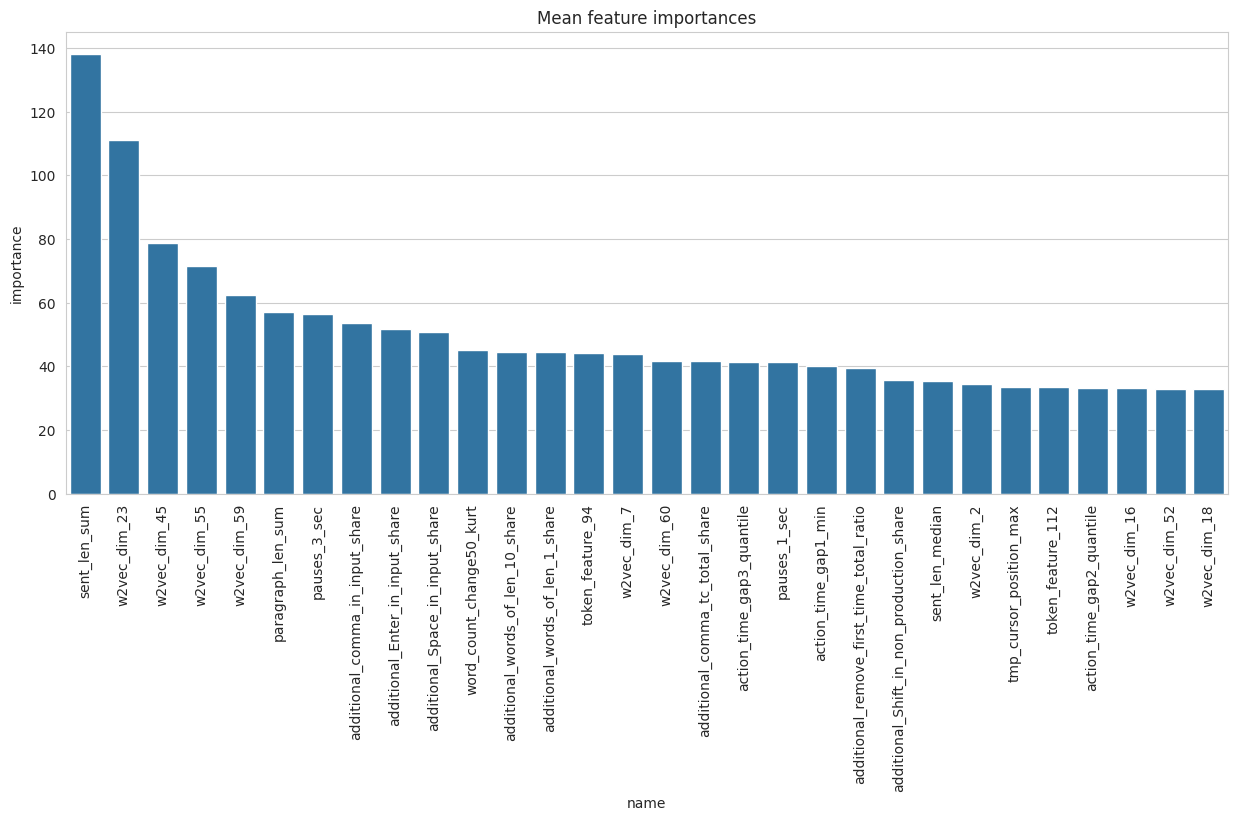

In [97]:
plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(30), x="name", y="importance")
ax.set_title(f"Mean feature importances")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

# Predicting The Test Set

We use the mean of all the predictions for all the fold models

In [98]:
# test_predict_list

In [99]:
if cnfg.is_local:
    # test_feats_df["pred_score"] = np.mean(test_predict_list, axis=0)
    test_rmse = metrics.mean_squared_error(
        test_feats["score"], np.mean(test_predict_list, axis=0), squared=False
    )
    print("Test Set RMSE Score : ", test_rmse)
else:
    test_feats["score"] = np.mean(test_predict_list, axis=0)
    test_feats[["id", "score"]].to_csv("submission.csv", index=False)

Test Set RMSE Score :  0.6250251676120598
